<h1> Setting up HF and packages </h1>

In [1]:
from huggingface_hub import notebook_login
notebook_login()

/Users/kunalbhandarkar/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
!huggingface-cli whoami

ShaanShah1


In [3]:
from llama_cpp import Llama
import time
import torch
from transformers import AutoTokenizer
from huggingface_hub import hf_hub_download
import psutil
import matplotlib.pyplot as plt
import json
import os
from tqdm import tqdm
import ast
import re

<h1> List of Models to Analyze </h1>

In [4]:
os.listdir("model_outputs_quant")

['Llama-3_2-1B-Instruct_IQ1_M_gguf.txt',
 'Llama-3_2-1B-Instruct_Q2_K_gguf.txt',
 'Llama-3_2-1B-Instruct_Q4_K_M_gguf.txt',
 'Llama-3_2-1B-Instruct_Q8_0_gguf.txt',
 'Llama-3_2-3B-Instruct_IQ1_M_gguf.txt',
 'Llama-3_2-3B-Instruct_Q2_K_gguf.txt',
 'Llama-3_2-3B-Instruct_Q4_K_M_gguf.txt',
 'Llama-3_2-3B-Instruct_Q8_0_gguf.txt',
 'Meta-Llama-3-8B-Instruct_IQ1_M_gguf.txt',
 'Meta-Llama-3-8B-Instruct_IQ2_XS_gguf.txt',
 'Meta-Llama-3-8B-Instruct_Q4_K_S_gguf.txt',
 'Meta-Llama-3-8B-Instruct_Q8_0_gguf.txt']

In [5]:
list_of_model_outputs = os.listdir("model_outputs_quant")
file_name_to_model_name = {
    'Llama-3_2-1B-Instruct_IQ1_M_gguf.txt': 'Llama 3.2 1B 1-bit',
    'Llama-3_2-1B-Instruct_Q2_K_gguf.txt': 'Llama 3.2 1B 2-bit',
    'Llama-3_2-1B-Instruct_Q4_K_M_gguf.txt': 'Llama 3.2 1B 4-bit',
    'Llama-3_2-1B-Instruct_Q8_0_gguf.txt': 'Llama 3.2 1B 8-bit',
    'Llama-3_2-3B-Instruct_IQ1_M_gguf.txt': 'Llama 3.2 3B 1-bit',
    'Llama-3_2-3B-Instruct_Q2_K_gguf.txt': 'Llama 3.2 3B 2-bit',
    'Llama-3_2-3B-Instruct_Q4_K_M_gguf.txt': 'Llama 3.2 3B 4-bit',
    'Llama-3_2-3B-Instruct_Q8_0_gguf.txt': 'Llama 3.2 3B 8-bit',
    'Meta-Llama-3-8B-Instruct_IQ1_M_gguf.txt': 'Llama 3.0 8B 1-bit',
    'Meta-Llama-3-8B-Instruct_IQ2_XS_gguf.txt': 'Llama 3.0 8B 2-bit',
    'Meta-Llama-3-8B-Instruct_Q4_K_S_gguf.txt': 'Llama 3.0 8B 4-bit',
    'Meta-Llama-3-8B-Instruct_Q8_0_gguf.txt': 'Llama 3.0 8B 8-bit'
}


<h1> Reading in the model data </h1>

In [6]:
def read_model_outputs(model_name):
    """
    Reads the output file for the given model and returns a list of dictionaries,
    each representing the results for one prompt.

    Args:
        model_name (str): The original model name (e.g., "some/model").

    Returns:
        list: A list of dictionaries read from the file.
    """
    # Sanitize the model name (replace "/" with "_") to match the file naming
    model_name_sanitized = model_name.replace("/", "_")
    file_path = f"model_outputs_quant/{model_name_sanitized}"
    
    results = []
    
    # Check if the file exists
    if not os.path.exists(file_path):
        print(f"No output file found for model '{model_name_sanitized}'.")
        print(f"No output file found for model '{model_name}'.")
        return results
    
    # Open and read the file line by line
    with open(file_path, "r", encoding="utf-8") as infile:
        for line in infile:
            line = line.strip()
            if line:
                try:
                    # Convert the string representation of the dictionary into a dict
                    result_dict = ast.literal_eval(line)
                    results.append(result_dict)
                except Exception as e:
                    print(f"Error parsing line: {line}\nError: {e}")
                    
    return results

<h1> Eval Code </h1>

In [7]:
def eval_answer(model_output, answer_key):
    """
    Evaluates the model output by scanning the entire string for the answer_key.
    
    For numeric answer_keys, it searches for any number (allowing an optional '$' and commas)
    that, when converted to a float, equals answer_key. For non-numeric answer_keys, it checks
    whether the answer_key appears anywhere in the string.
    
    Returns:
        1 if a matching answer is found, 0 otherwise.
    """
    # Determine whether answer_key is numeric.
    try:
        answer_key_numeric = float(answer_key)
        answer_key_is_numeric = True
    except (ValueError, TypeError):
        answer_key_is_numeric = False

    if answer_key_is_numeric:
        # Find all numeric tokens in the model output. The regex allows an optional '$' and commas.
        numbers = re.findall(r"\$?([-+]?\d[\d,]*\.?\d*)", model_output)
        for num in numbers:
            # Remove commas from the extracted number.
            num_clean = num.replace(',', '')
            try:
                extracted_num = float(num_clean)
            except ValueError:
                continue  # Skip if conversion fails.
            # Compare the extracted number with the answer_key.
            if extracted_num == answer_key_numeric:
                print(f"Found matching numeric answer: {extracted_num} equals answer key: {answer_key_numeric}")
                return 1
        print("No matching numeric answer found in model output.")
        return 0
    else:
        # For non-numeric answer keys, check if the answer_key appears anywhere in the output.
        # Using re.search to allow for case-sensitive matching.
        if re.search(re.escape(str(answer_key)), model_output):
            print(f"Found matching string answer: '{answer_key}' in model output.")
            return 1
        else:
            print("No matching string answer found in model output.")
            return 0

# Example usage:
example1_model = ("Janet has 16 eggs per day, so 16 - 3 = 13 eggs left. "
                  "13 eggs * 4 eggs per muffin = 52 muffins per day. 52 muffins * $2 per muffin = 104 dollars per day.")
example1_key = 104.0  # Expected to return 1 since 104 appears in the string.

example2_model = "2 bolts of blue fiber, and 2.5 bolts of white fiber. 2 + 2.5 = 4.5."
example2_key = 4.5   # Expected to return 1 since 4.5 appears in the string.

example3_model = "The result computed is twenty."
example3_key = "twenty"   # Expected to return 1 since 'twenty' appears in the string.

print("Result for example 1:", eval_answer(example1_model, example1_key))
print("Result for example 2:", eval_answer(example2_model, example2_key))
print("Result for example 3:", eval_answer(example3_model, example3_key))


Found matching numeric answer: 104.0 equals answer key: 104.0
Result for example 1: 1
Found matching numeric answer: 4.5 equals answer key: 4.5
Result for example 2: 1
Found matching string answer: 'twenty' in model output.
Result for example 3: 1


In [8]:
final_model_results = {}
for model_index in range(len(list_of_model_outputs)):
    data_out = read_model_outputs(list_of_model_outputs[model_index])
    eval_result = 0
    count = 0
    latency = 0 
    throughput = 0
    max_ram = 0 
    tokens_generated = 0
    for i in range(len(data_out)):
        count += 1
    print(f"Model: {file_name_to_model_name[list_of_model_outputs[model_index]]}", count)

Model: Llama 3.2 1B 1-bit 120
Model: Llama 3.2 1B 2-bit 120
Model: Llama 3.2 1B 4-bit 351
Model: Llama 3.2 1B 8-bit 120
Model: Llama 3.2 3B 1-bit 120
Model: Llama 3.2 3B 2-bit 120
Model: Llama 3.2 3B 4-bit 120
Model: Llama 3.2 3B 8-bit 120
Model: Llama 3.0 8B 1-bit 120
Model: Llama 3.0 8B 2-bit 120
Model: Llama 3.0 8B 4-bit 120
Model: Llama 3.0 8B 8-bit 120


In [9]:
final_model_results = {}
for model_index in range(len(list_of_model_outputs)):
    data_out = read_model_outputs(list_of_model_outputs[model_index])
    print(f"Model: {file_name_to_model_name[list_of_model_outputs[model_index]]}")
    eval_result = 0
    count = 0
    latency = 0 
    throughput = 0
    max_ram = 0 
    tokens_generated = 0
    for i in range(len(data_out)):
        eval_result += eval_answer(data_out[i]['model_output'], data_out[i]['answer'])
        latency += data_out[i]['latency']
        throughput += data_out[i]['throughput'] 
        max_ram += data_out[i]['max_ram']
        tokens_generated += data_out[i]['tokens_generated']
        count += 1
    print(f"Accuracy: {eval_result/count}")
    dict_to_save = {
        "Accuracy": eval_result/count, 
        "Latency": latency/count,
        "Throughput": throughput/count,
        "Max RAM": max_ram/count,
        "Tokens Generated": tokens_generated/count
    }
    final_model_results[file_name_to_model_name[list_of_model_outputs[model_index]]] = dict_to_save

Model: Llama 3.2 1B 1-bit
No matching numeric answer found in model output.
No matching numeric answer found in model output.
No matching numeric answer found in model output.
No matching numeric answer found in model output.
No matching numeric answer found in model output.
No matching numeric answer found in model output.
No matching numeric answer found in model output.
No matching numeric answer found in model output.
No matching numeric answer found in model output.
No matching numeric answer found in model output.
No matching numeric answer found in model output.
No matching numeric answer found in model output.
No matching numeric answer found in model output.
No matching numeric answer found in model output.
No matching numeric answer found in model output.
No matching numeric answer found in model output.
No matching numeric answer found in model output.
No matching numeric answer found in model output.
No matching numeric answer found in model output.
No matching numeric answ

In [10]:
final_model_results

{'Llama 3.2 1B 1-bit': {'Accuracy': 0.025,
  'Latency': 3.267399779955546,
  'Throughput': 53.96856315986919,
  'Max RAM': 0.9990121205647786,
  'Tokens Generated': 176.525},
 'Llama 3.2 1B 2-bit': {'Accuracy': 0.1,
  'Latency': 1.5778886119524638,
  'Throughput': 65.39124895872727,
  'Max RAM': 1.175499471028646,
  'Tokens Generated': 113.125},
 'Llama 3.2 1B 4-bit': {'Accuracy': 0.2706552706552707,
  'Latency': 2.6769594181636798,
  'Throughput': 57.1560541319685,
  'Max RAM': 1.3456260050803508,
  'Tokens Generated': 90.3048433048433},
 'Llama 3.2 1B 8-bit': {'Accuracy': 0.23333333333333334,
  'Latency': 1.2103675683339437,
  'Throughput': 53.67444331376857,
  'Max RAM': 1.8588766733805338,
  'Tokens Generated': 70.09166666666667},
 'Llama 3.2 3B 1-bit': {'Accuracy': 0.11666666666666667,
  'Latency': 8.462984438737234,
  'Throughput': 21.070240742522937,
  'Max RAM': 1.622705332438151,
  'Tokens Generated': 178.575},
 'Llama 3.2 3B 2-bit': {'Accuracy': 0.4166666666666667,
  'Latency

<h1> Plotting Data </h1>

In [19]:
def plot_model_metrics(model_names, metrics, units, model_data):
    """
    Plots bar graphs for each metric across the provided model names.

    Parameters:
    - model_names: list of str, the names of the models to include.
    - metrics: list of str, the metrics to plot (e.g., 'Latency', 'Throughput').
    - units: list of str, the corresponding units for each metric.
    - model_data: dict, where keys are model names and values are dictionaries 
                  containing the metric values.
    """
    
    for metric, unit in zip(metrics, units):
        # Extract metric values for the models (ignore models missing the metric)
        unit_str = f" ({unit})" if unit else ""
        values = []
        selected_models = []
        for model in model_names:
            if model in model_data and metric in model_data[model]:
                values.append(model_data[model][metric])
                selected_models.append(model)

        # Create a new figure for each metric with 350 dpi for publication quality
        plt.figure(figsize=(8, 5), dpi=350)

        # Plot bars with a custom color, bar width, and edge color
        bars = plt.bar(
            selected_models, 
            values, 
            color='#66b3ff',   # Light blue
            width=0.6         # Adjust as needed for thickness
        )
        
        # Add a title and axis labels with increased font sizes
        plt.title(f"{metric}{unit_str}", fontsize=16, pad=10)
        # plt.xlabel("Models", fontsize=14)
        plt.ylabel(f"{metric}{unit_str}", fontsize=14)

        # Rotate x-axis labels for clarity
        plt.xticks(rotation=0, ha='center', fontsize=12)
        plt.yticks(fontsize=12)

        # Add numeric labels on top of each bar with increased font size
        for bar in bars:
            height = bar.get_height()
            plt.text(
                bar.get_x() + bar.get_width() / 2,  # X position in center of bar
                height,                            # Y position just above the bar
                f"{height:.2f}",                   # Format to 2 decimal places
                ha='center', va='bottom', 
                fontsize=12
            )
        
        # Make layout fit nicely
        plt.tight_layout()
        plt.show()


In [20]:
ordered_model_names = ['Llama 3.2 1B 1-bit',
 'Llama 3.2 1B 2-bit',
 'Llama 3.2 1B 4-bit',
 'Llama 3.2 1B 8-bit',
 'Llama 3.2 3B 1-bit',
 'Llama 3.2 3B 2-bit',
 'Llama 3.2 3B 4-bit',
 'Llama 3.2 3B 8-bit',
 'Llama 3.0 8B 1-bit',
 'Llama 3.0 8B 2-bit',
 'Llama 3.0 8B 4-bit',
 'Llama 3.0 8B 8-bit']

metrics = ['Accuracy', 'Latency', 'Throughput', 'Max RAM', 'Tokens Generated']
units = ["", "s", "tokens/s", "GB", ""]

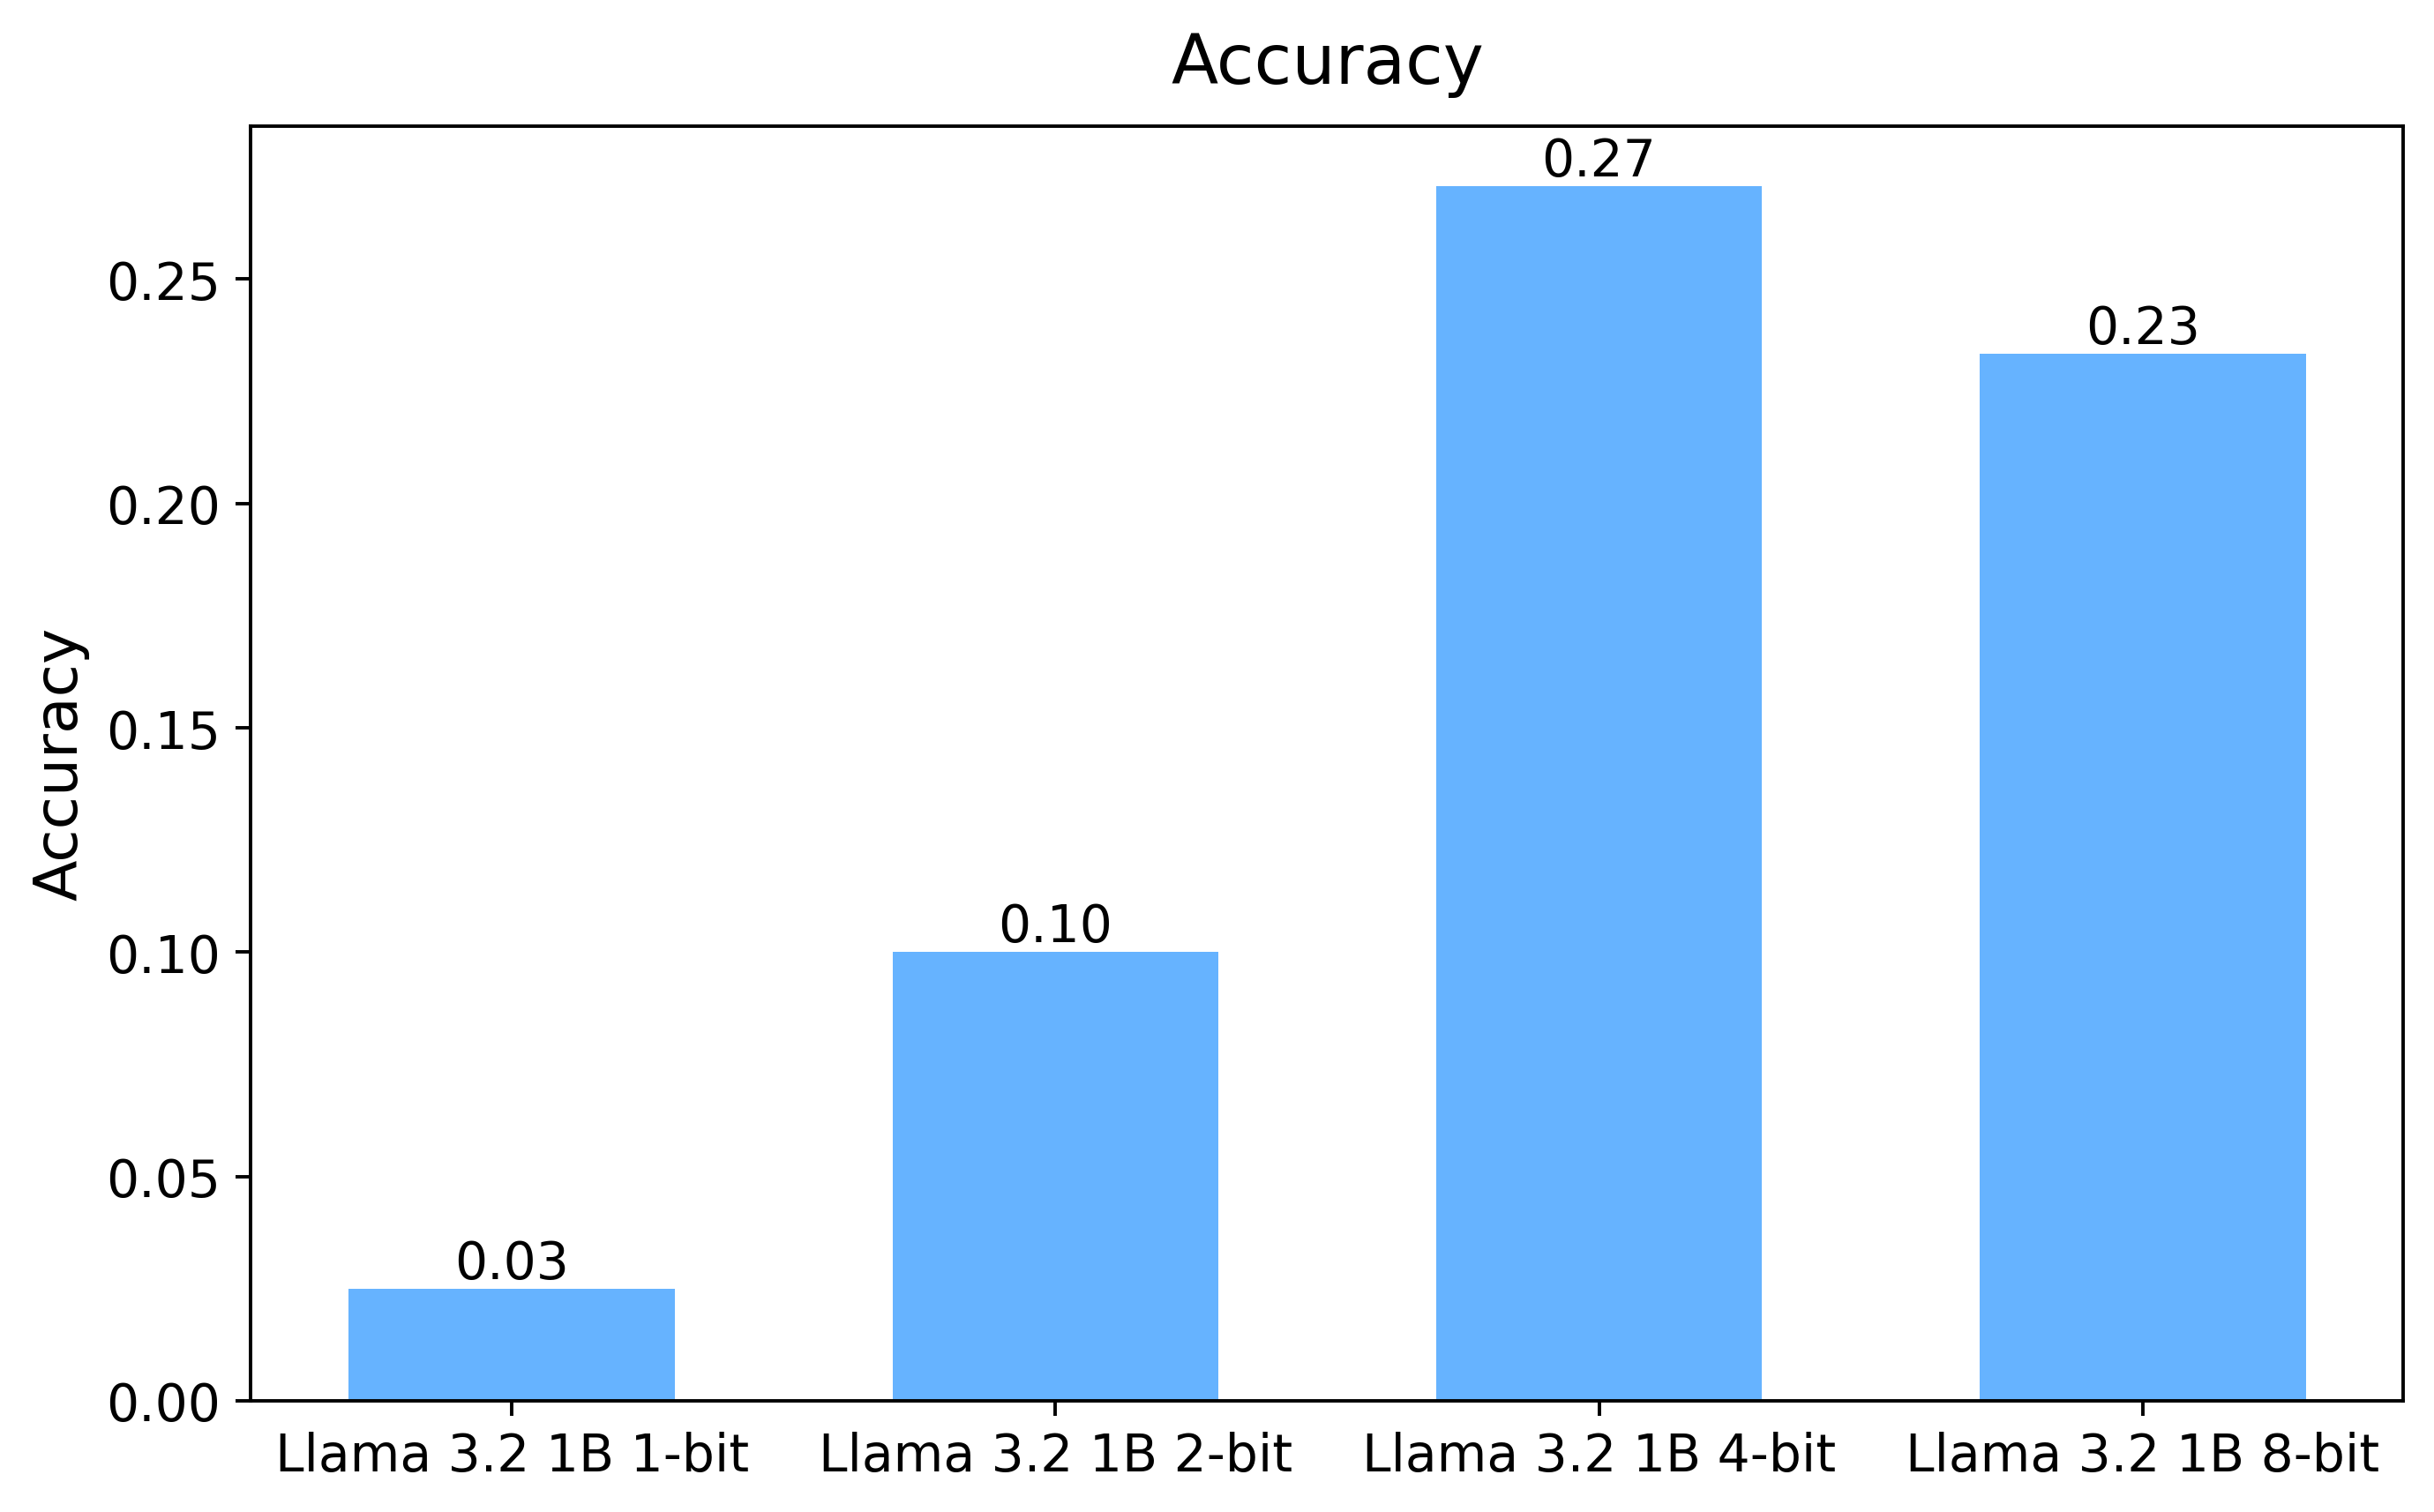

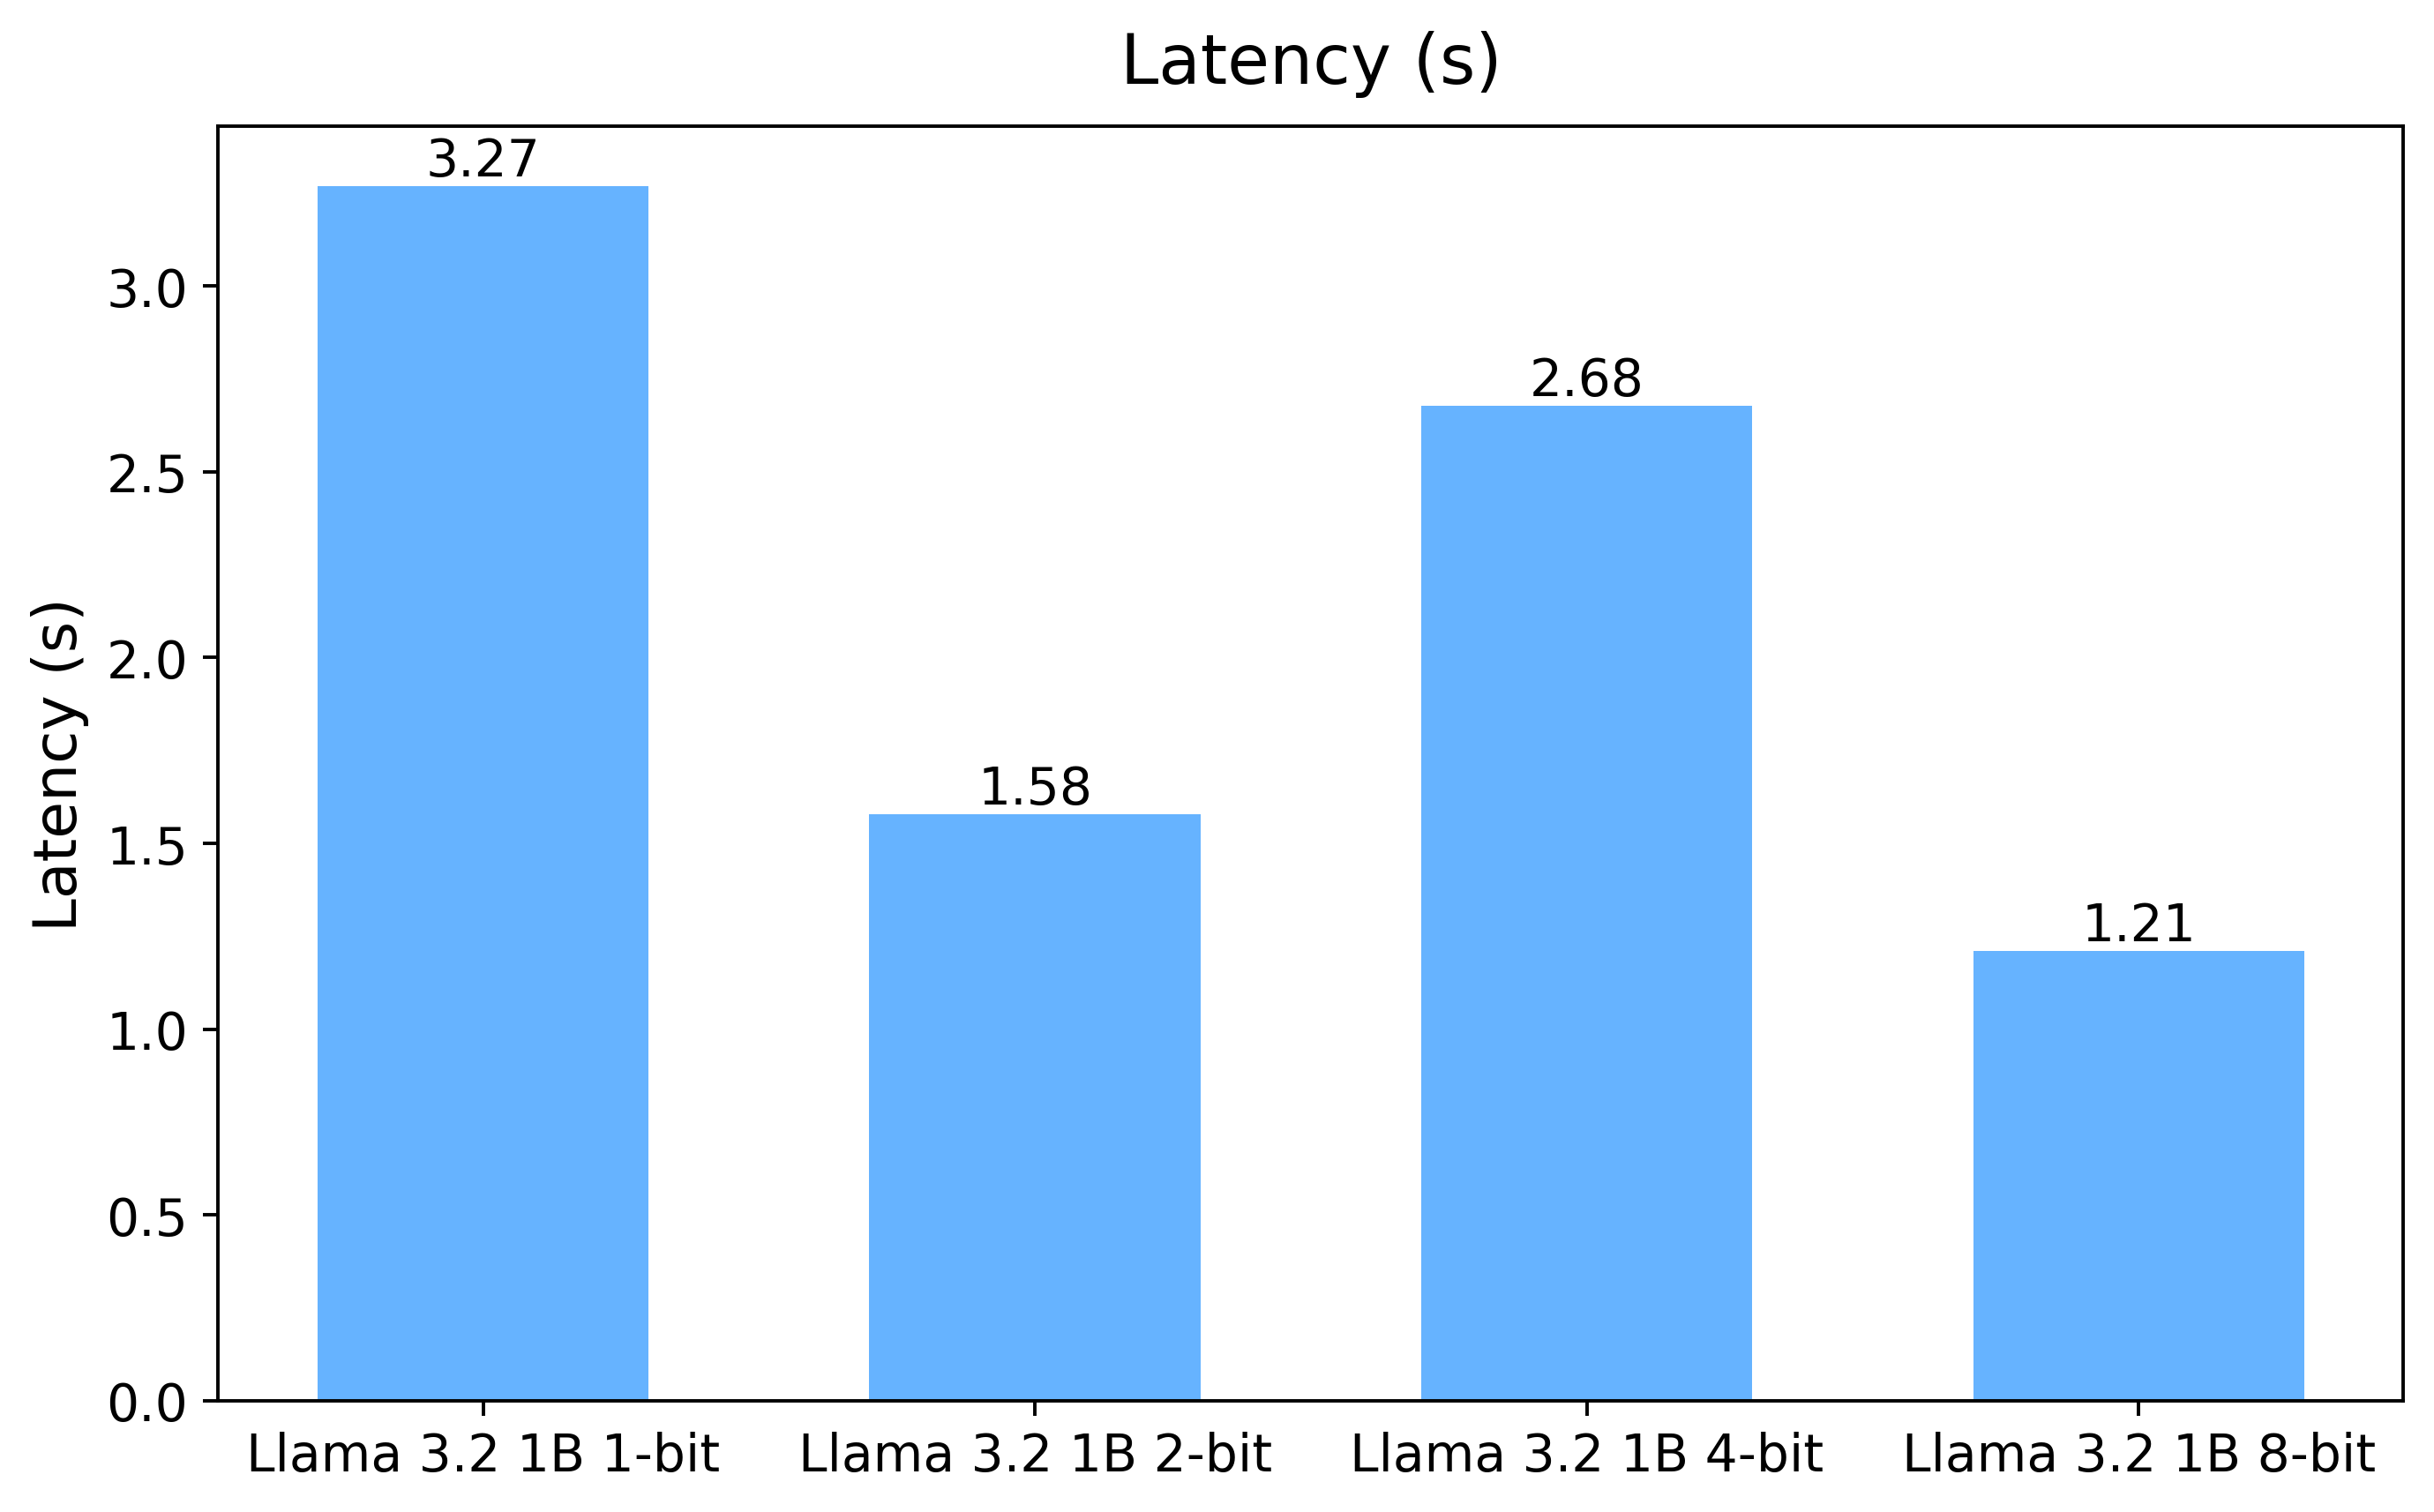

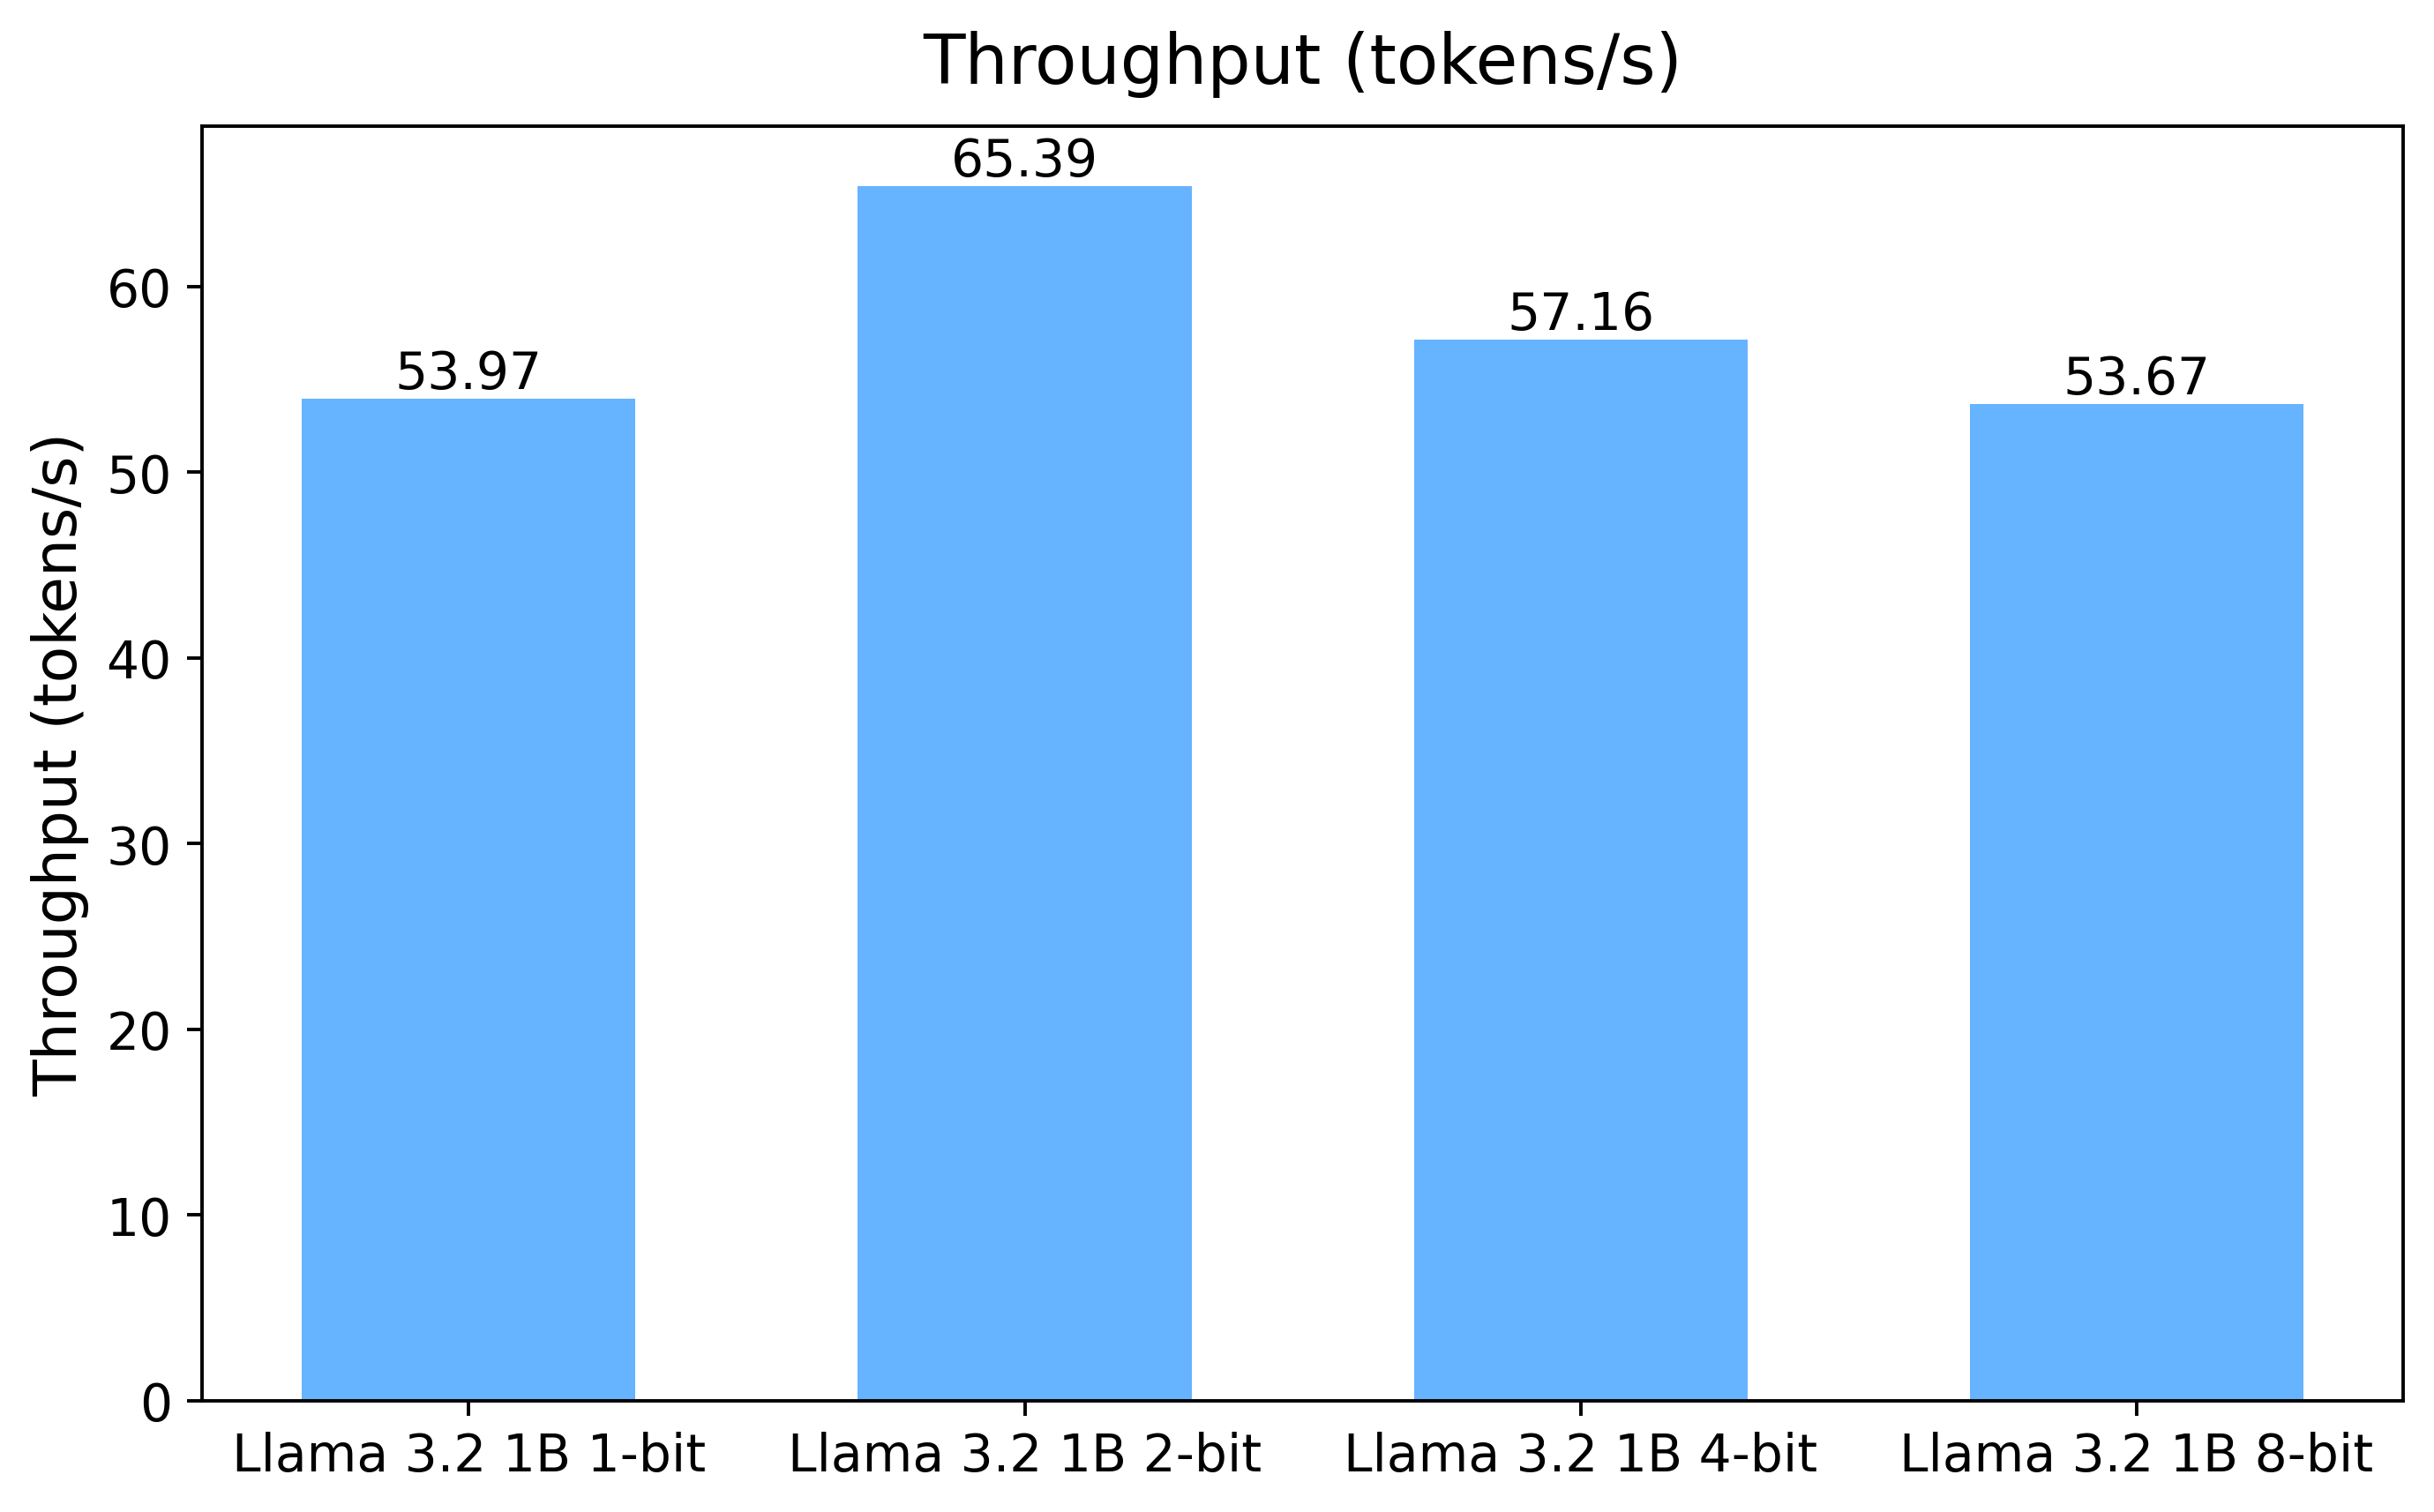

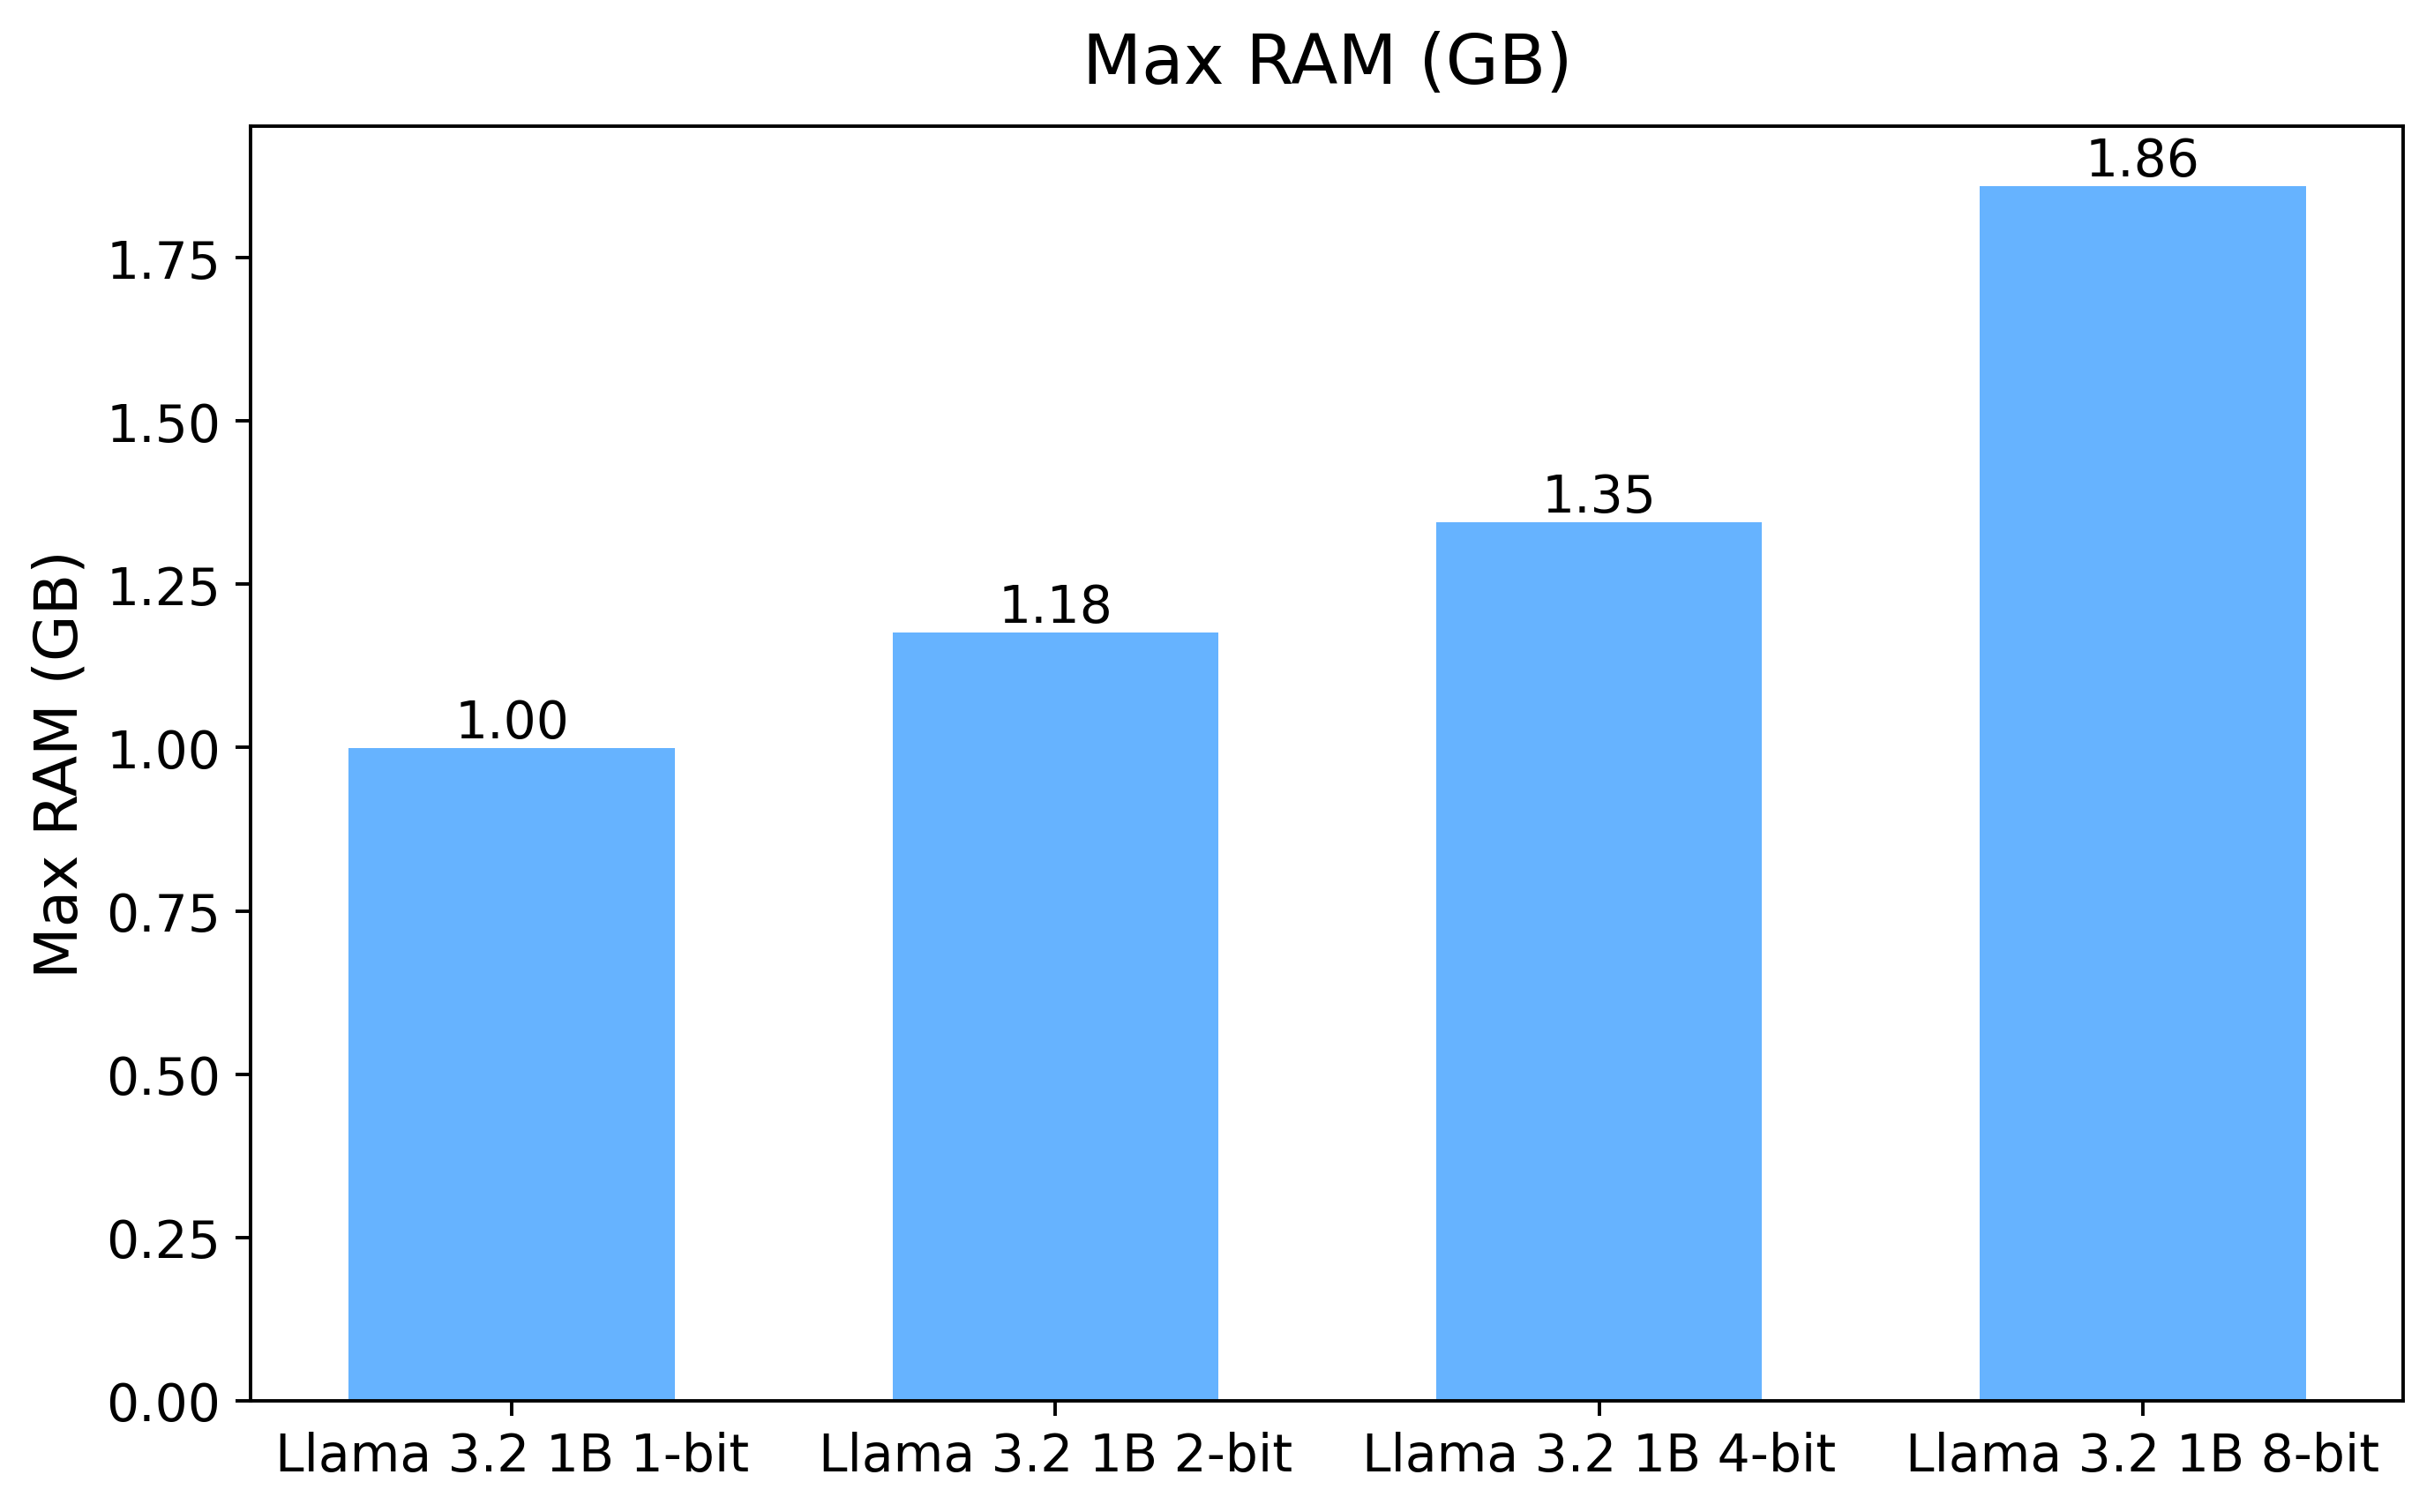

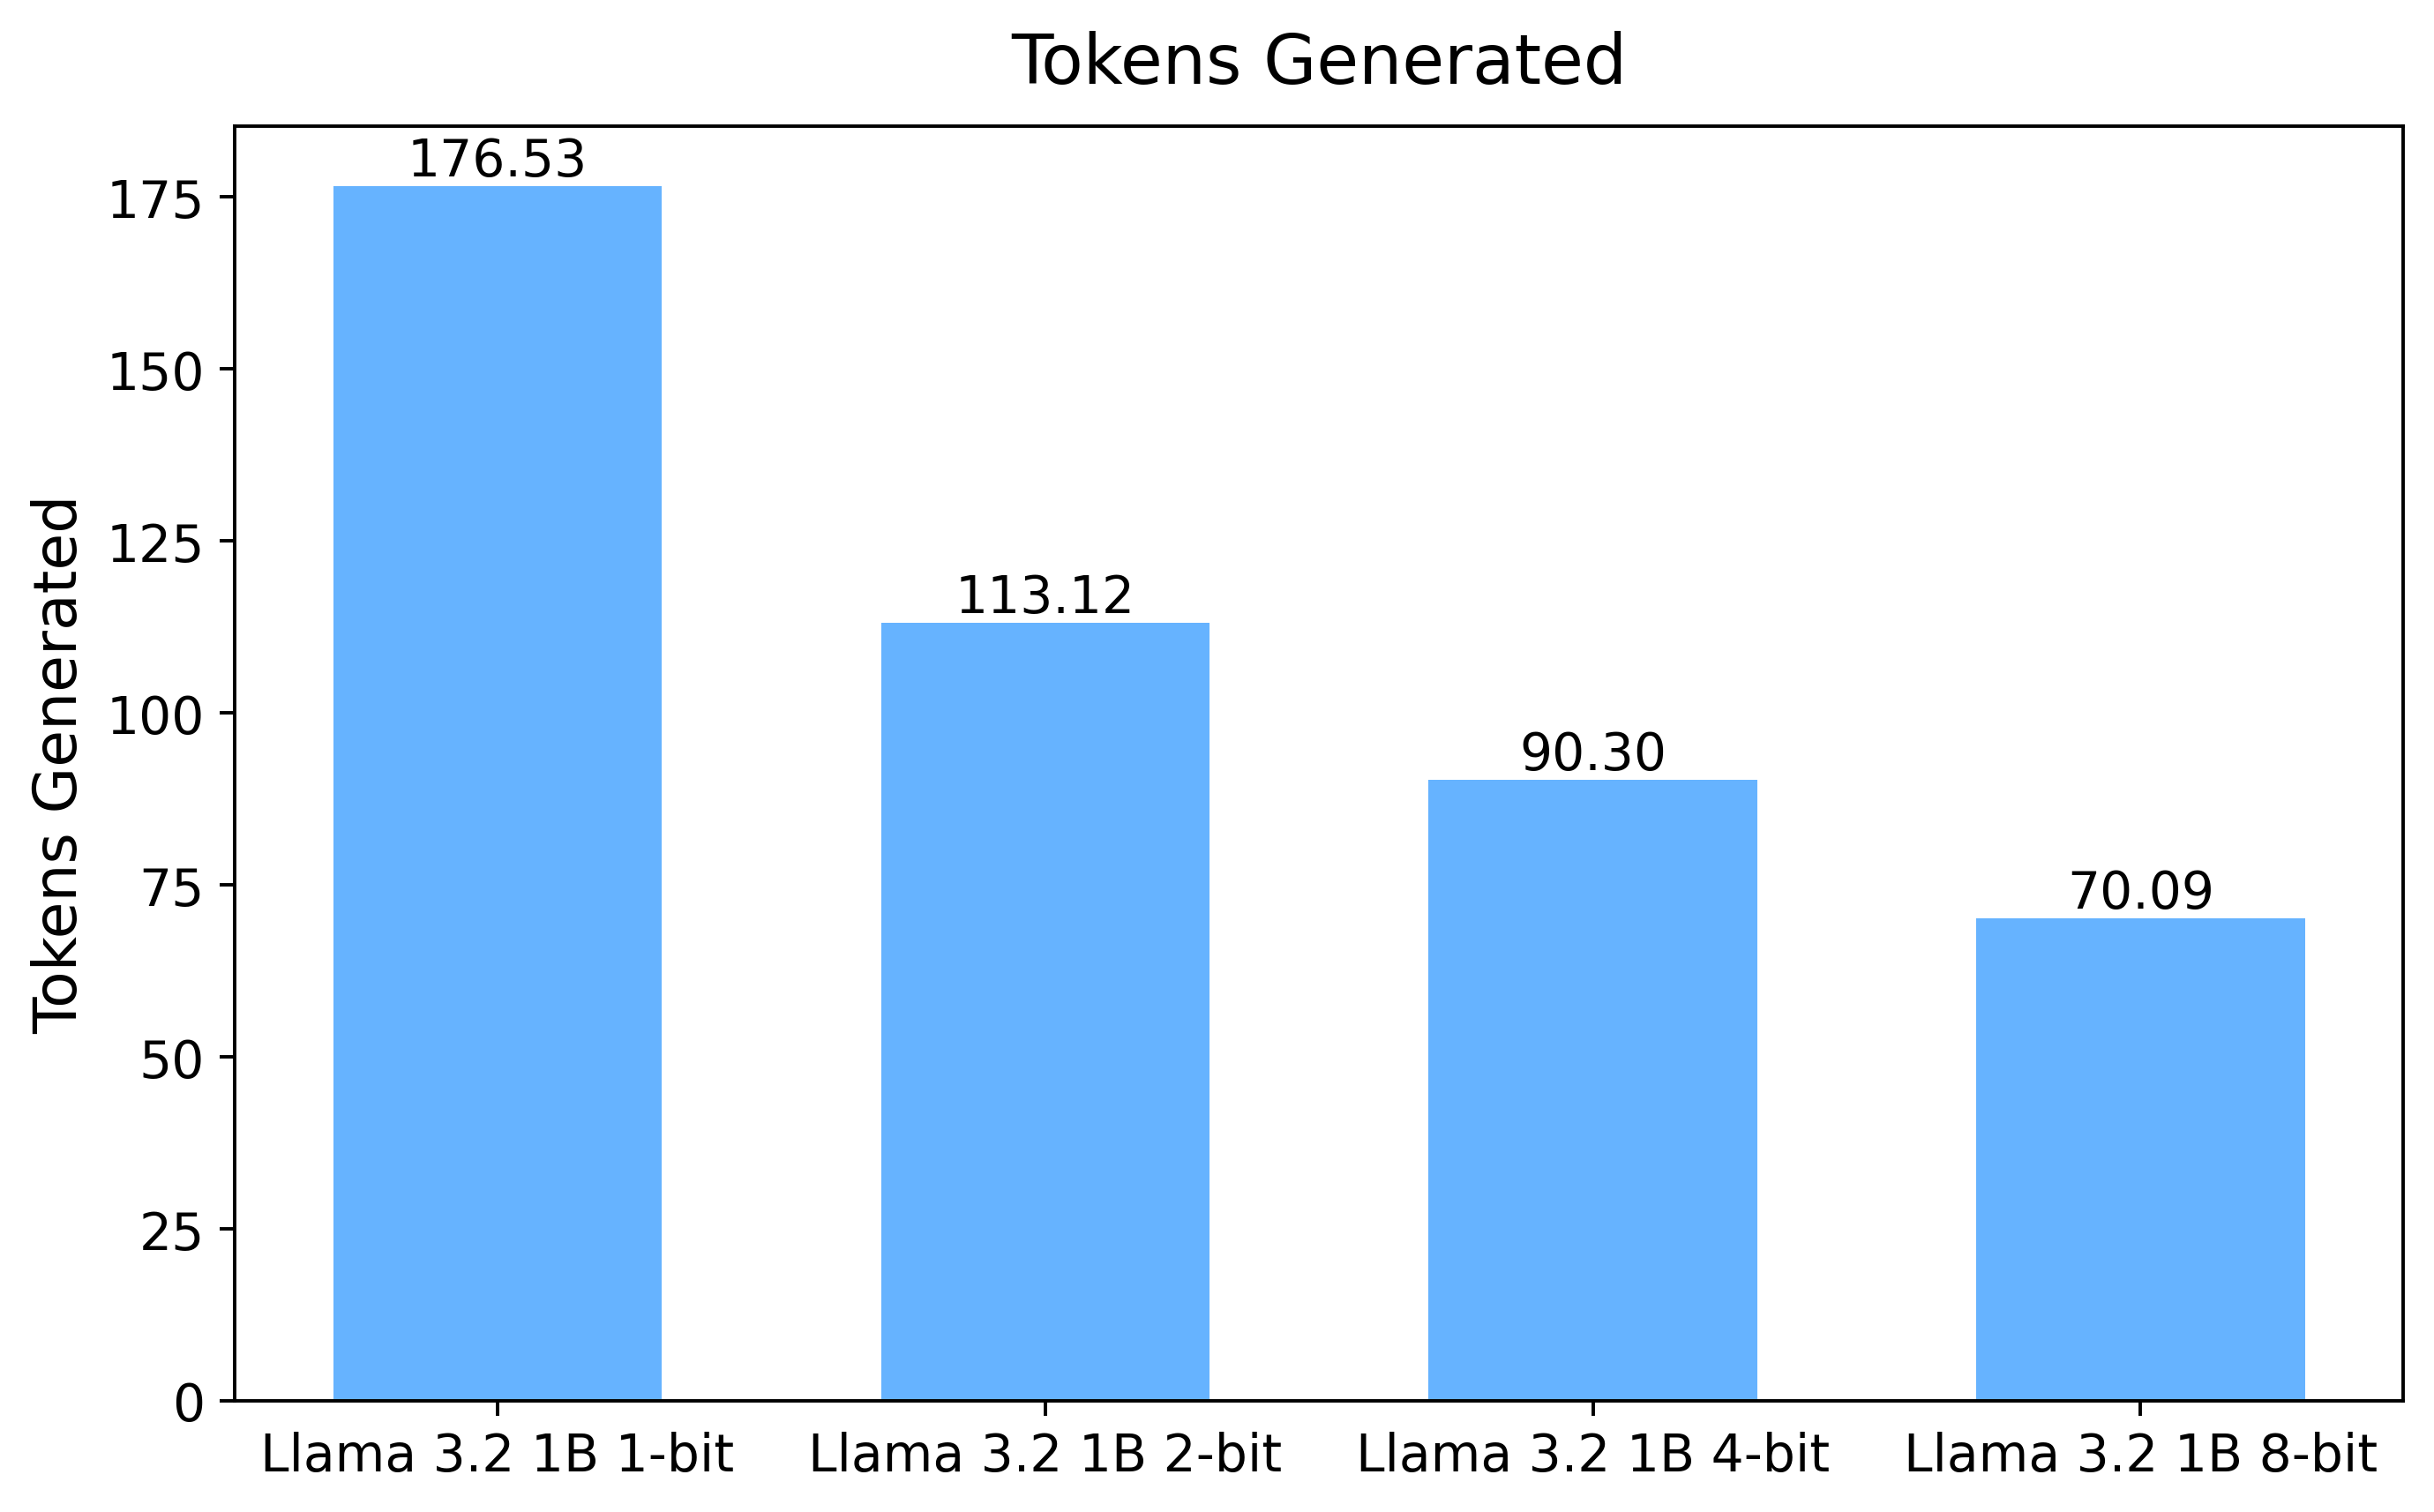

In [23]:
model_names = ['Llama 3.2 1B 1-bit',
 'Llama 3.2 1B 2-bit',
 'Llama 3.2 1B 4-bit',
 'Llama 3.2 1B 8-bit']

metrics = ['Accuracy', 'Latency', 'Throughput', 'Max RAM', 'Tokens Generated']
units = ["", "s", "tokens/s", "GB", ""]
plot_model_metrics(model_names, metrics, units, final_model_results, )

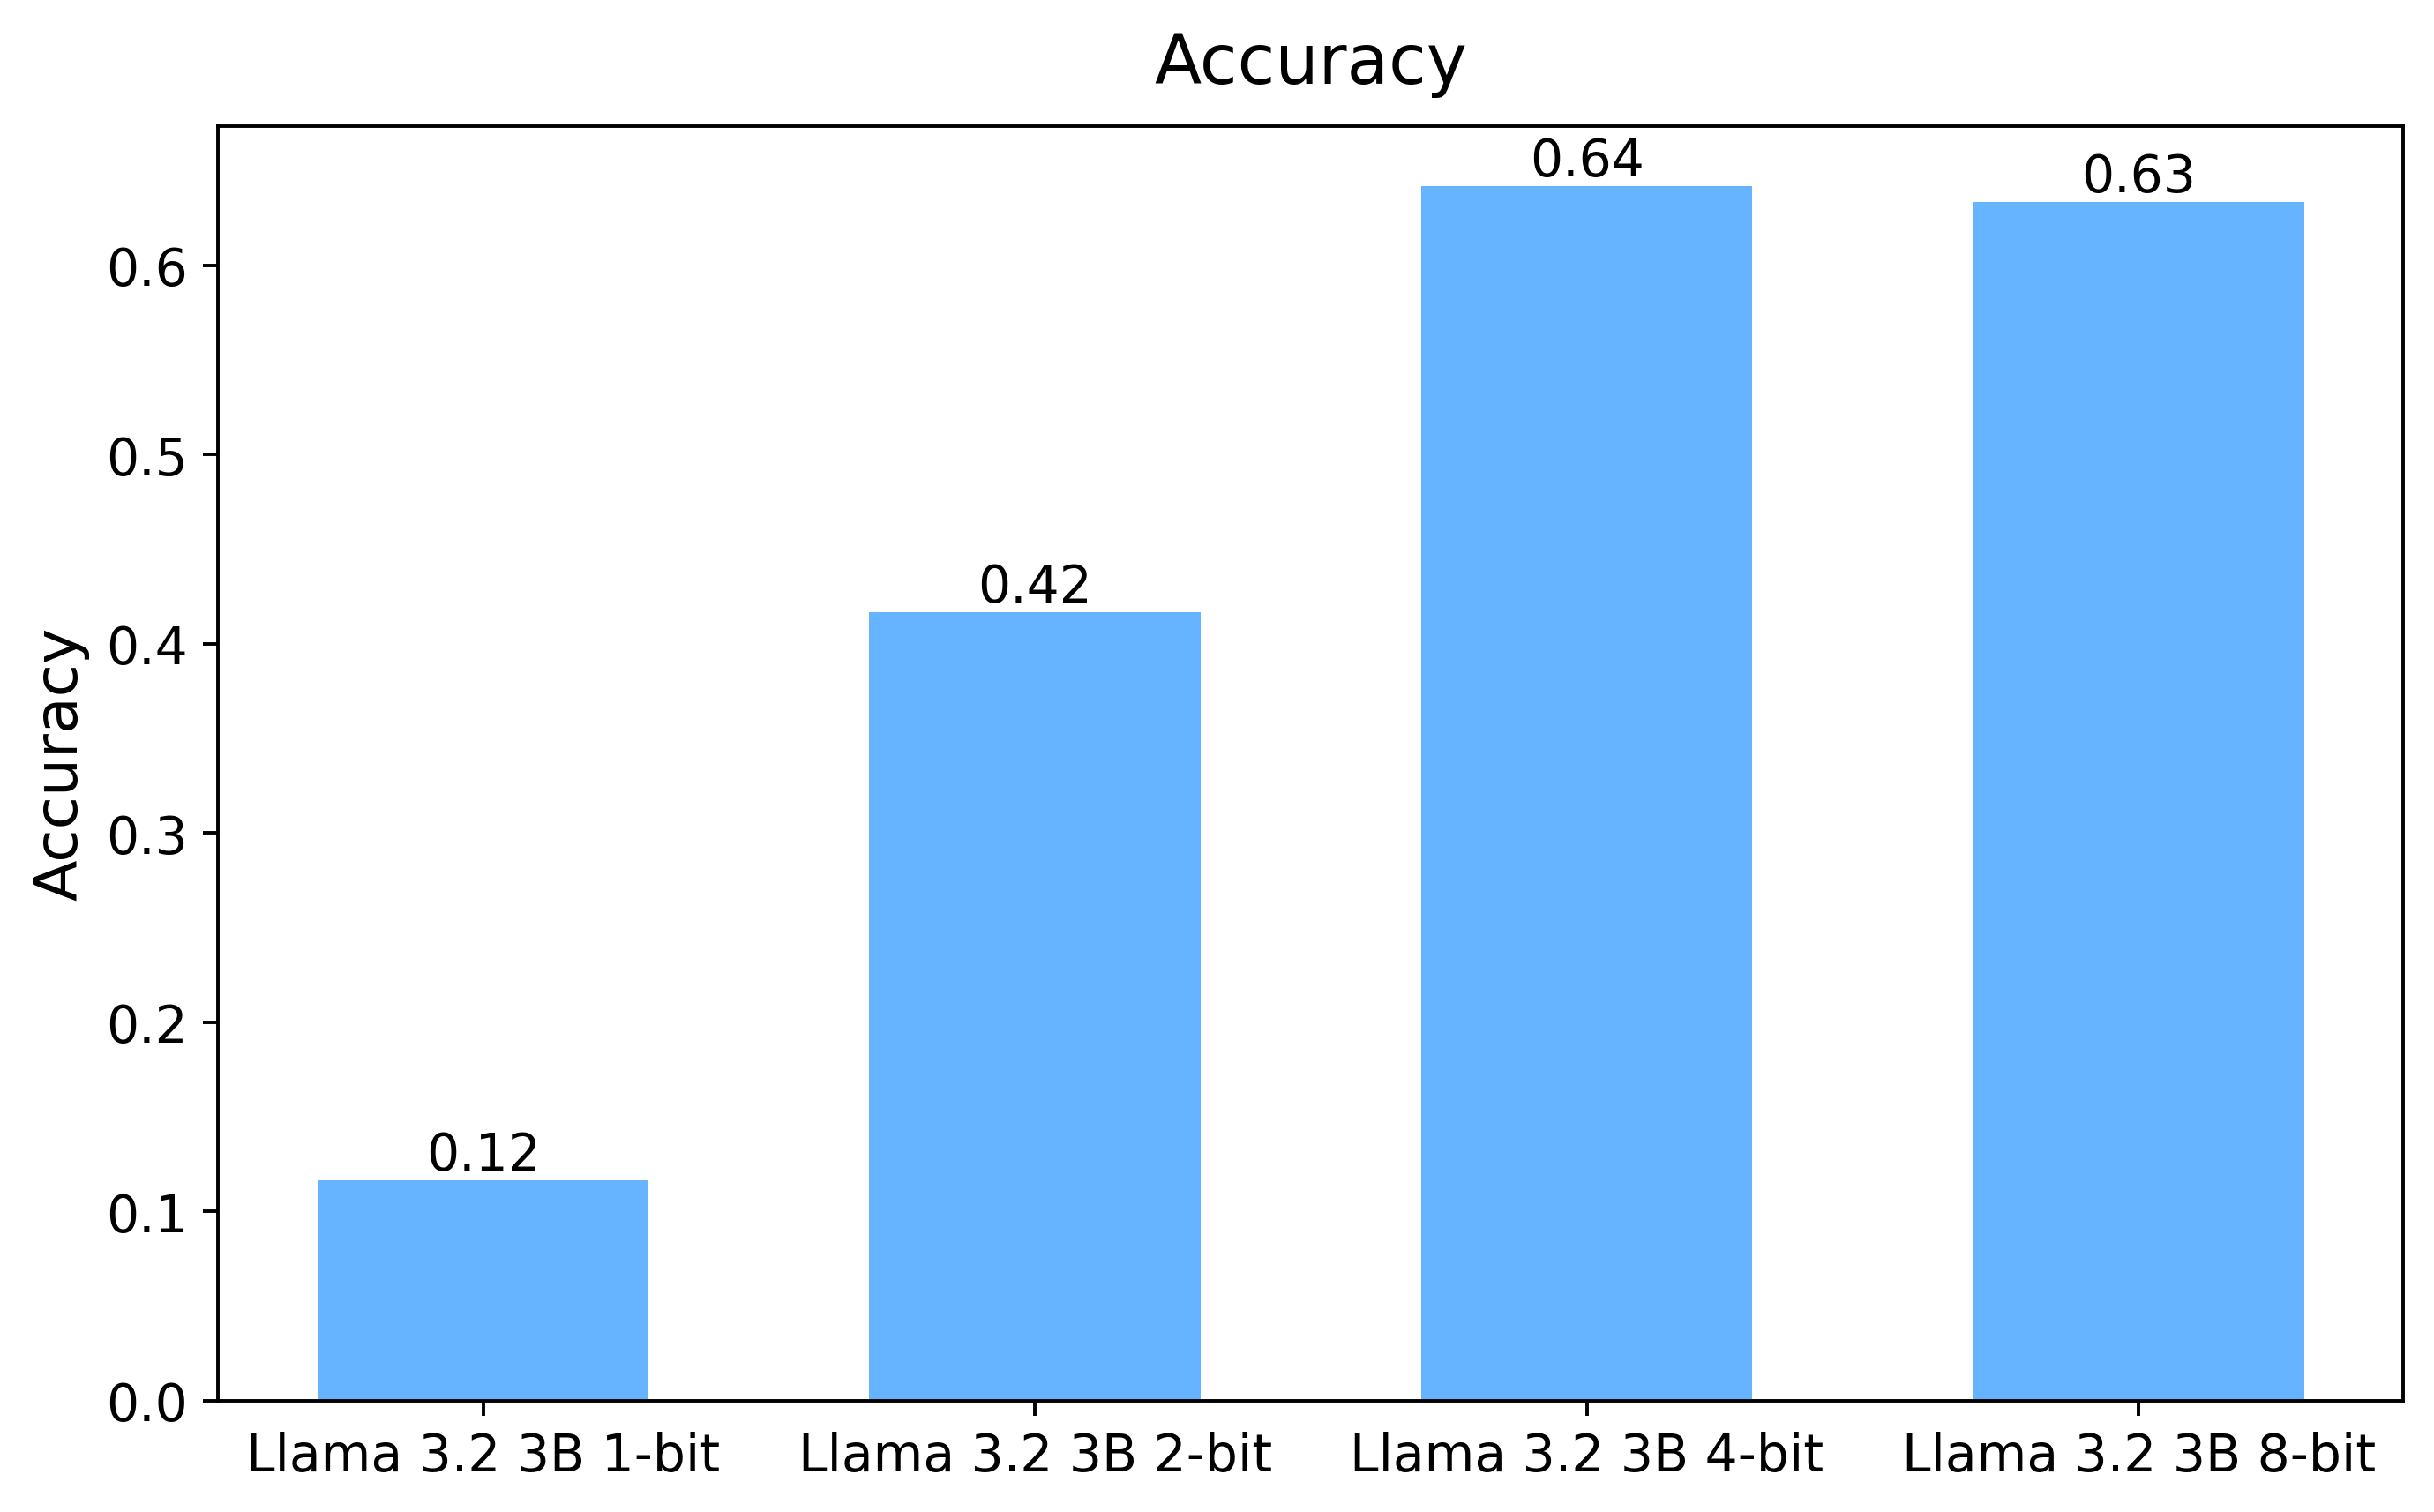

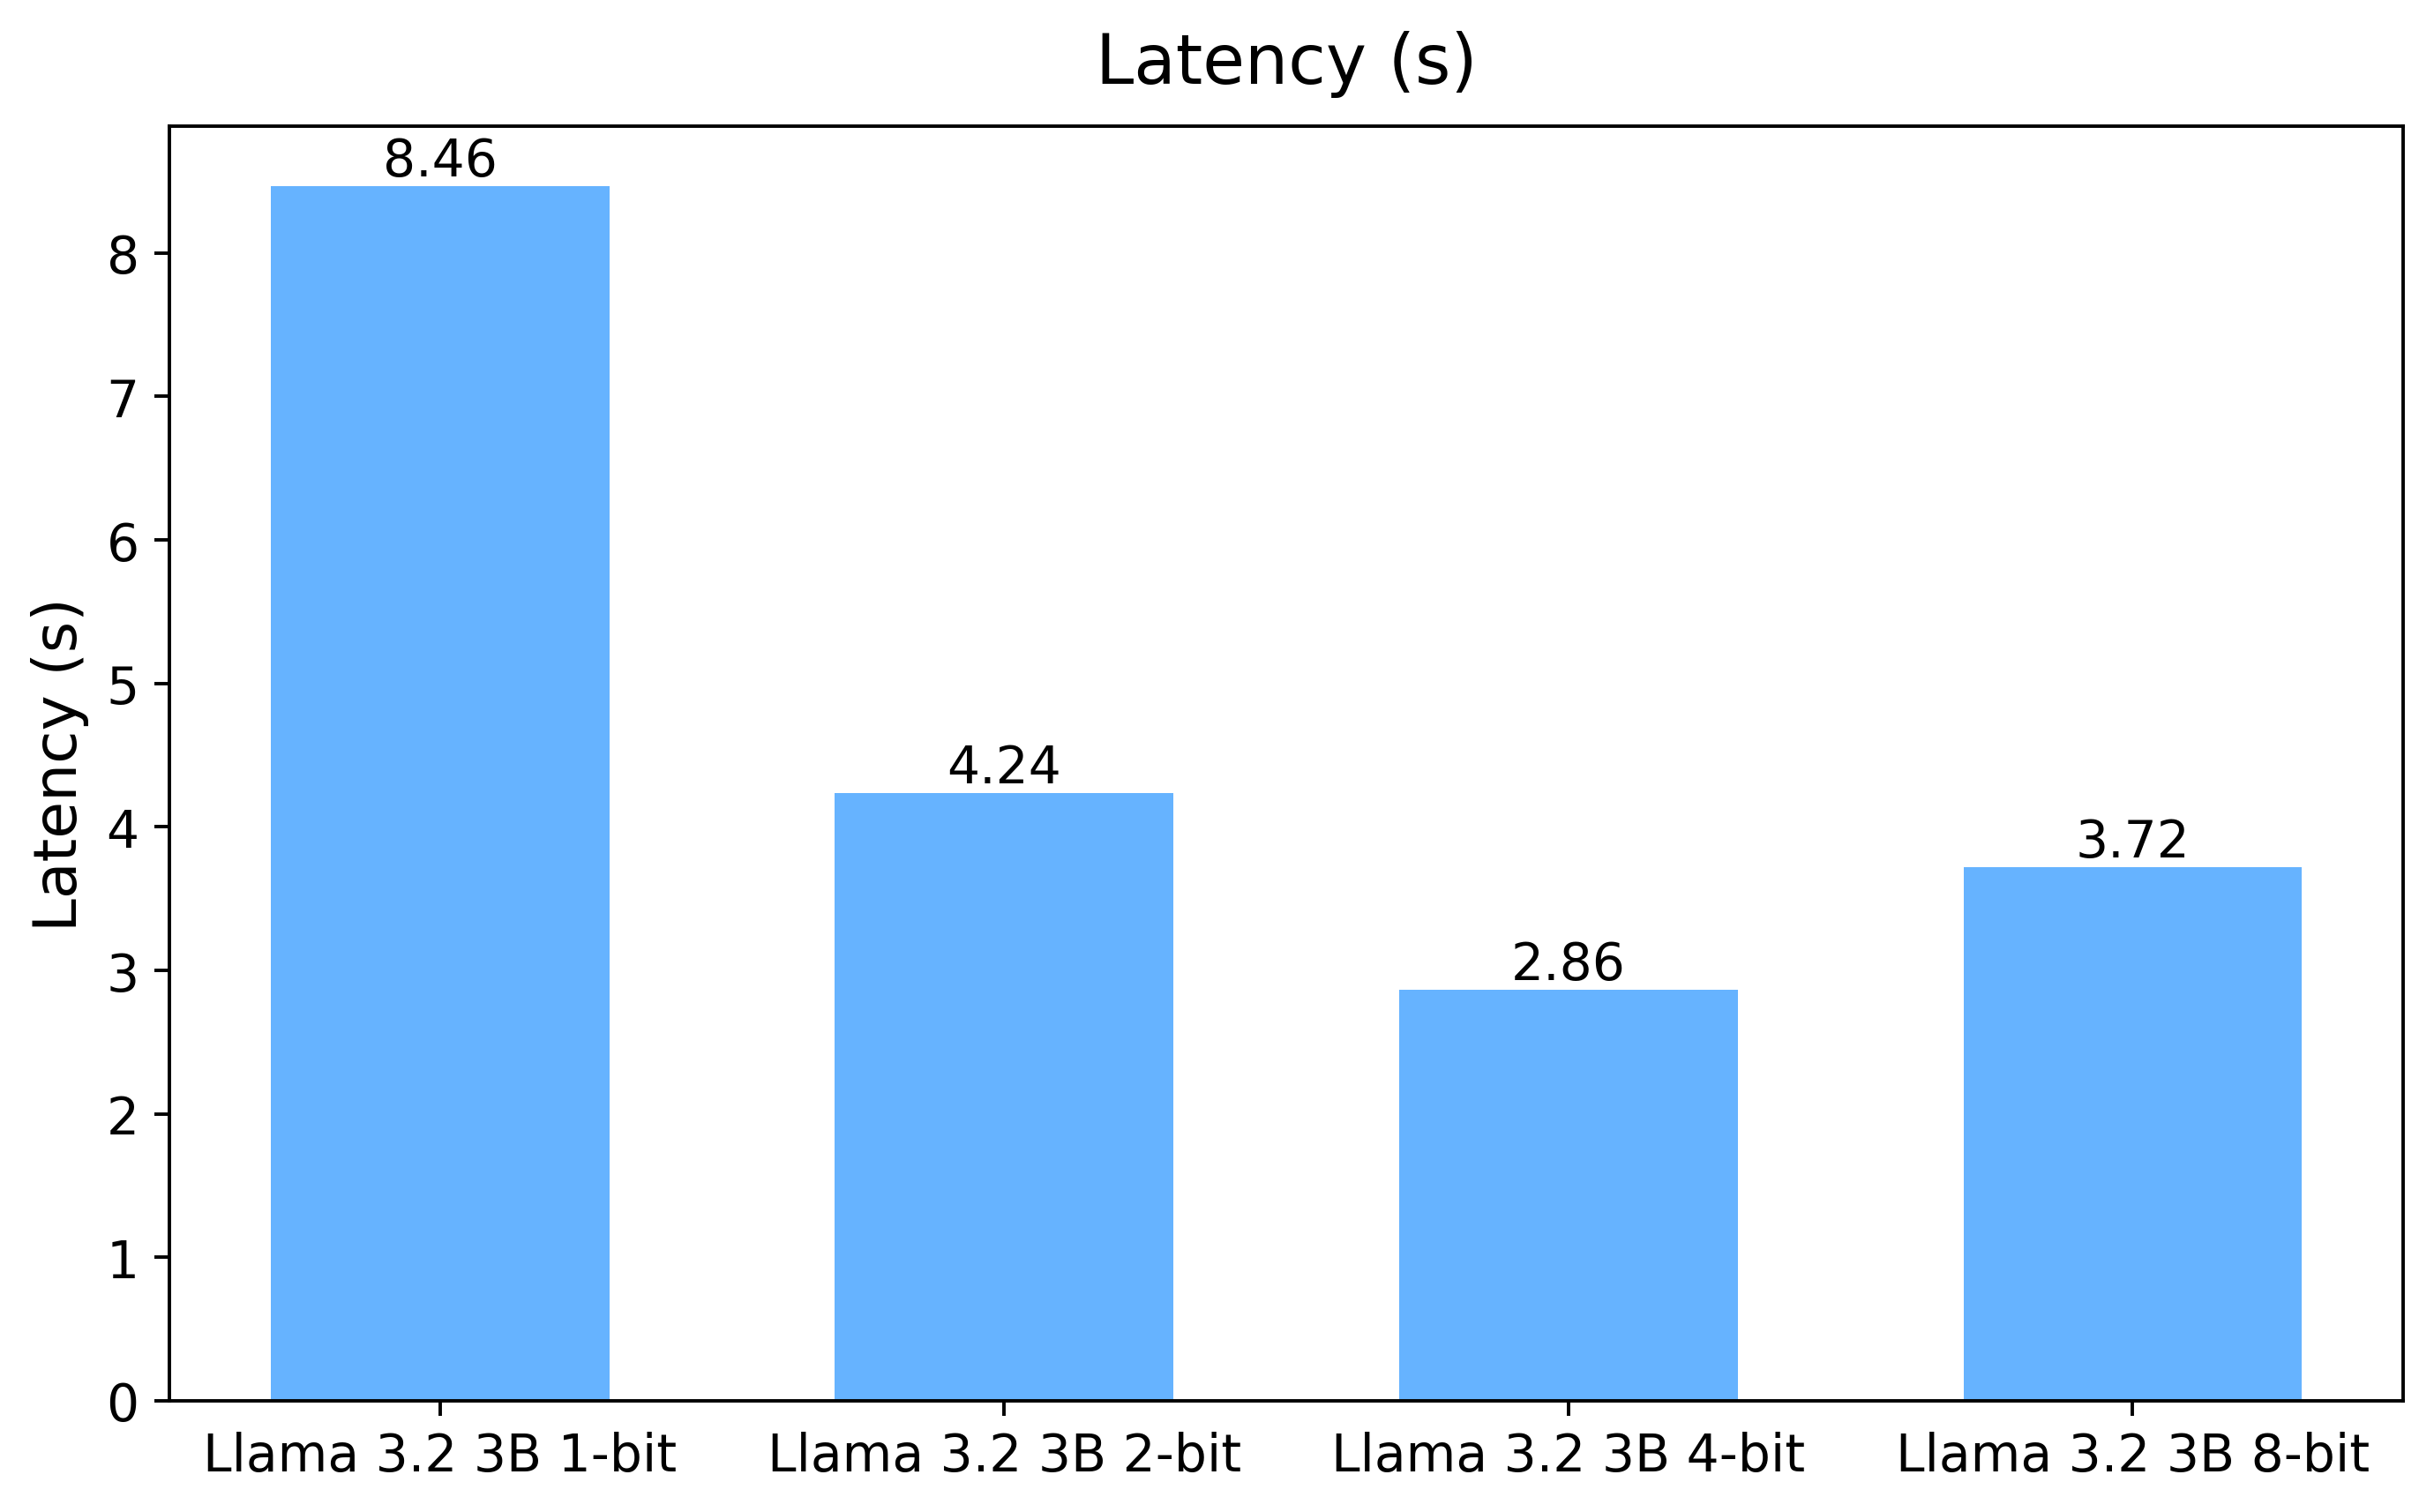

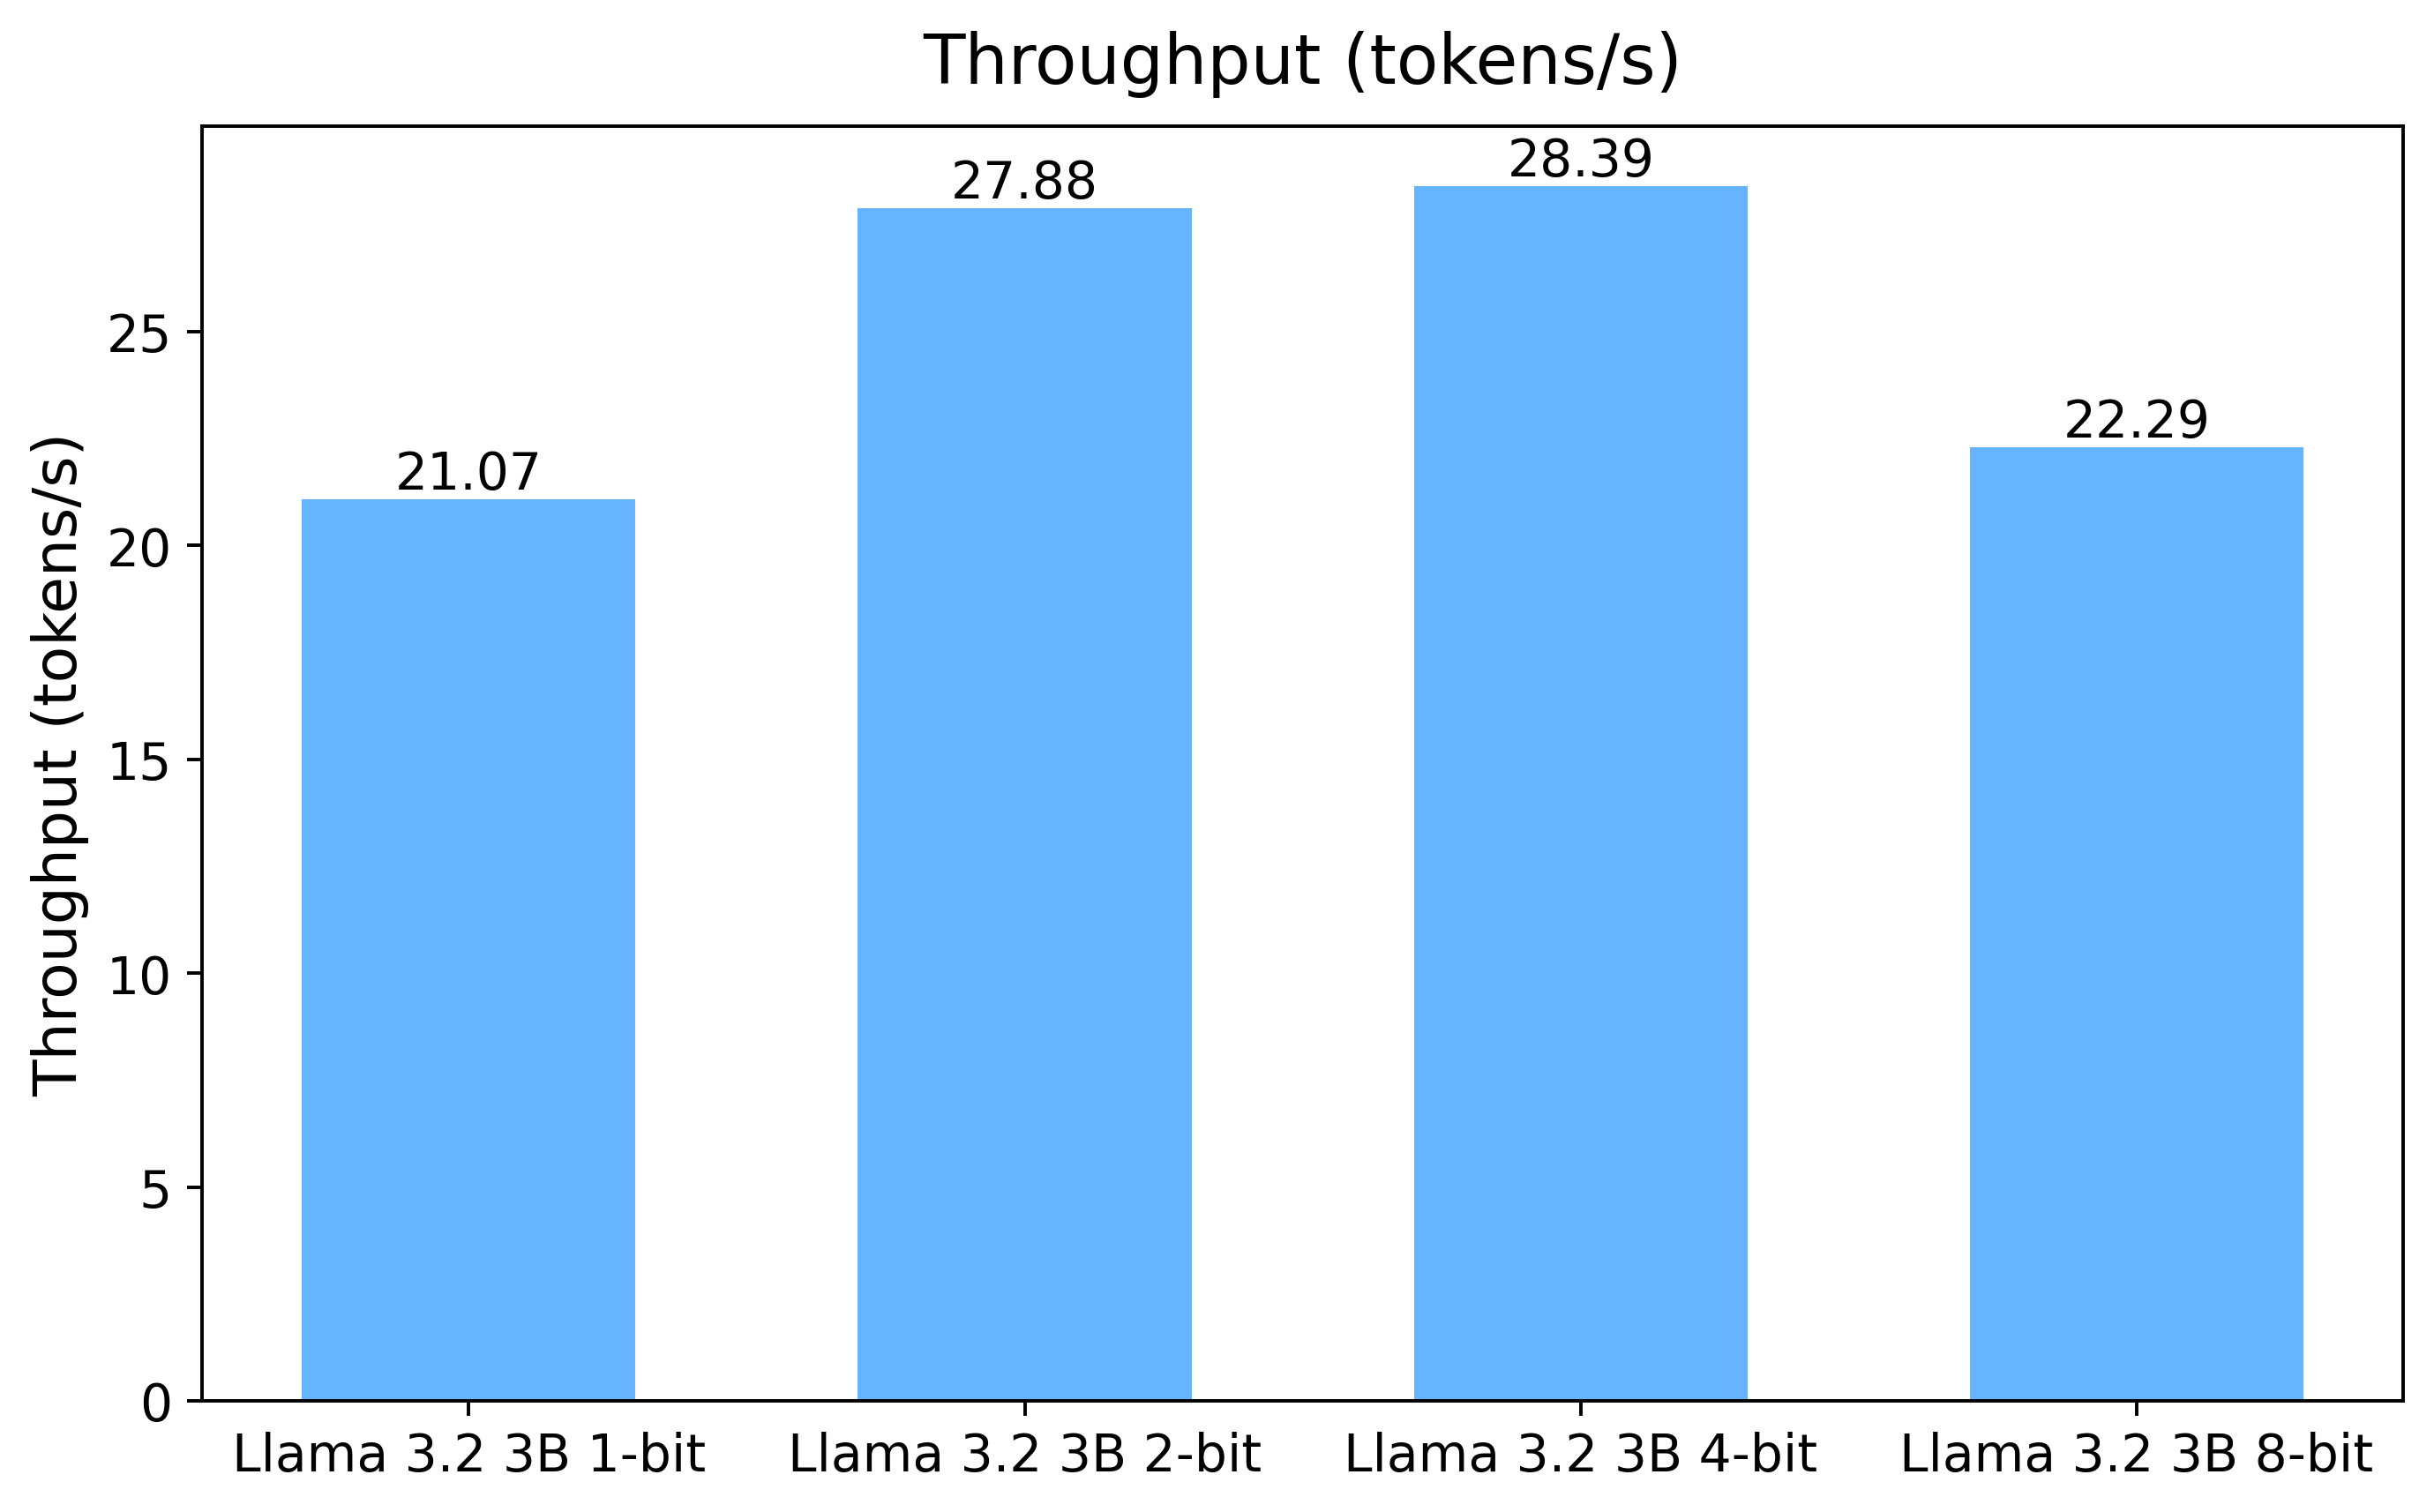

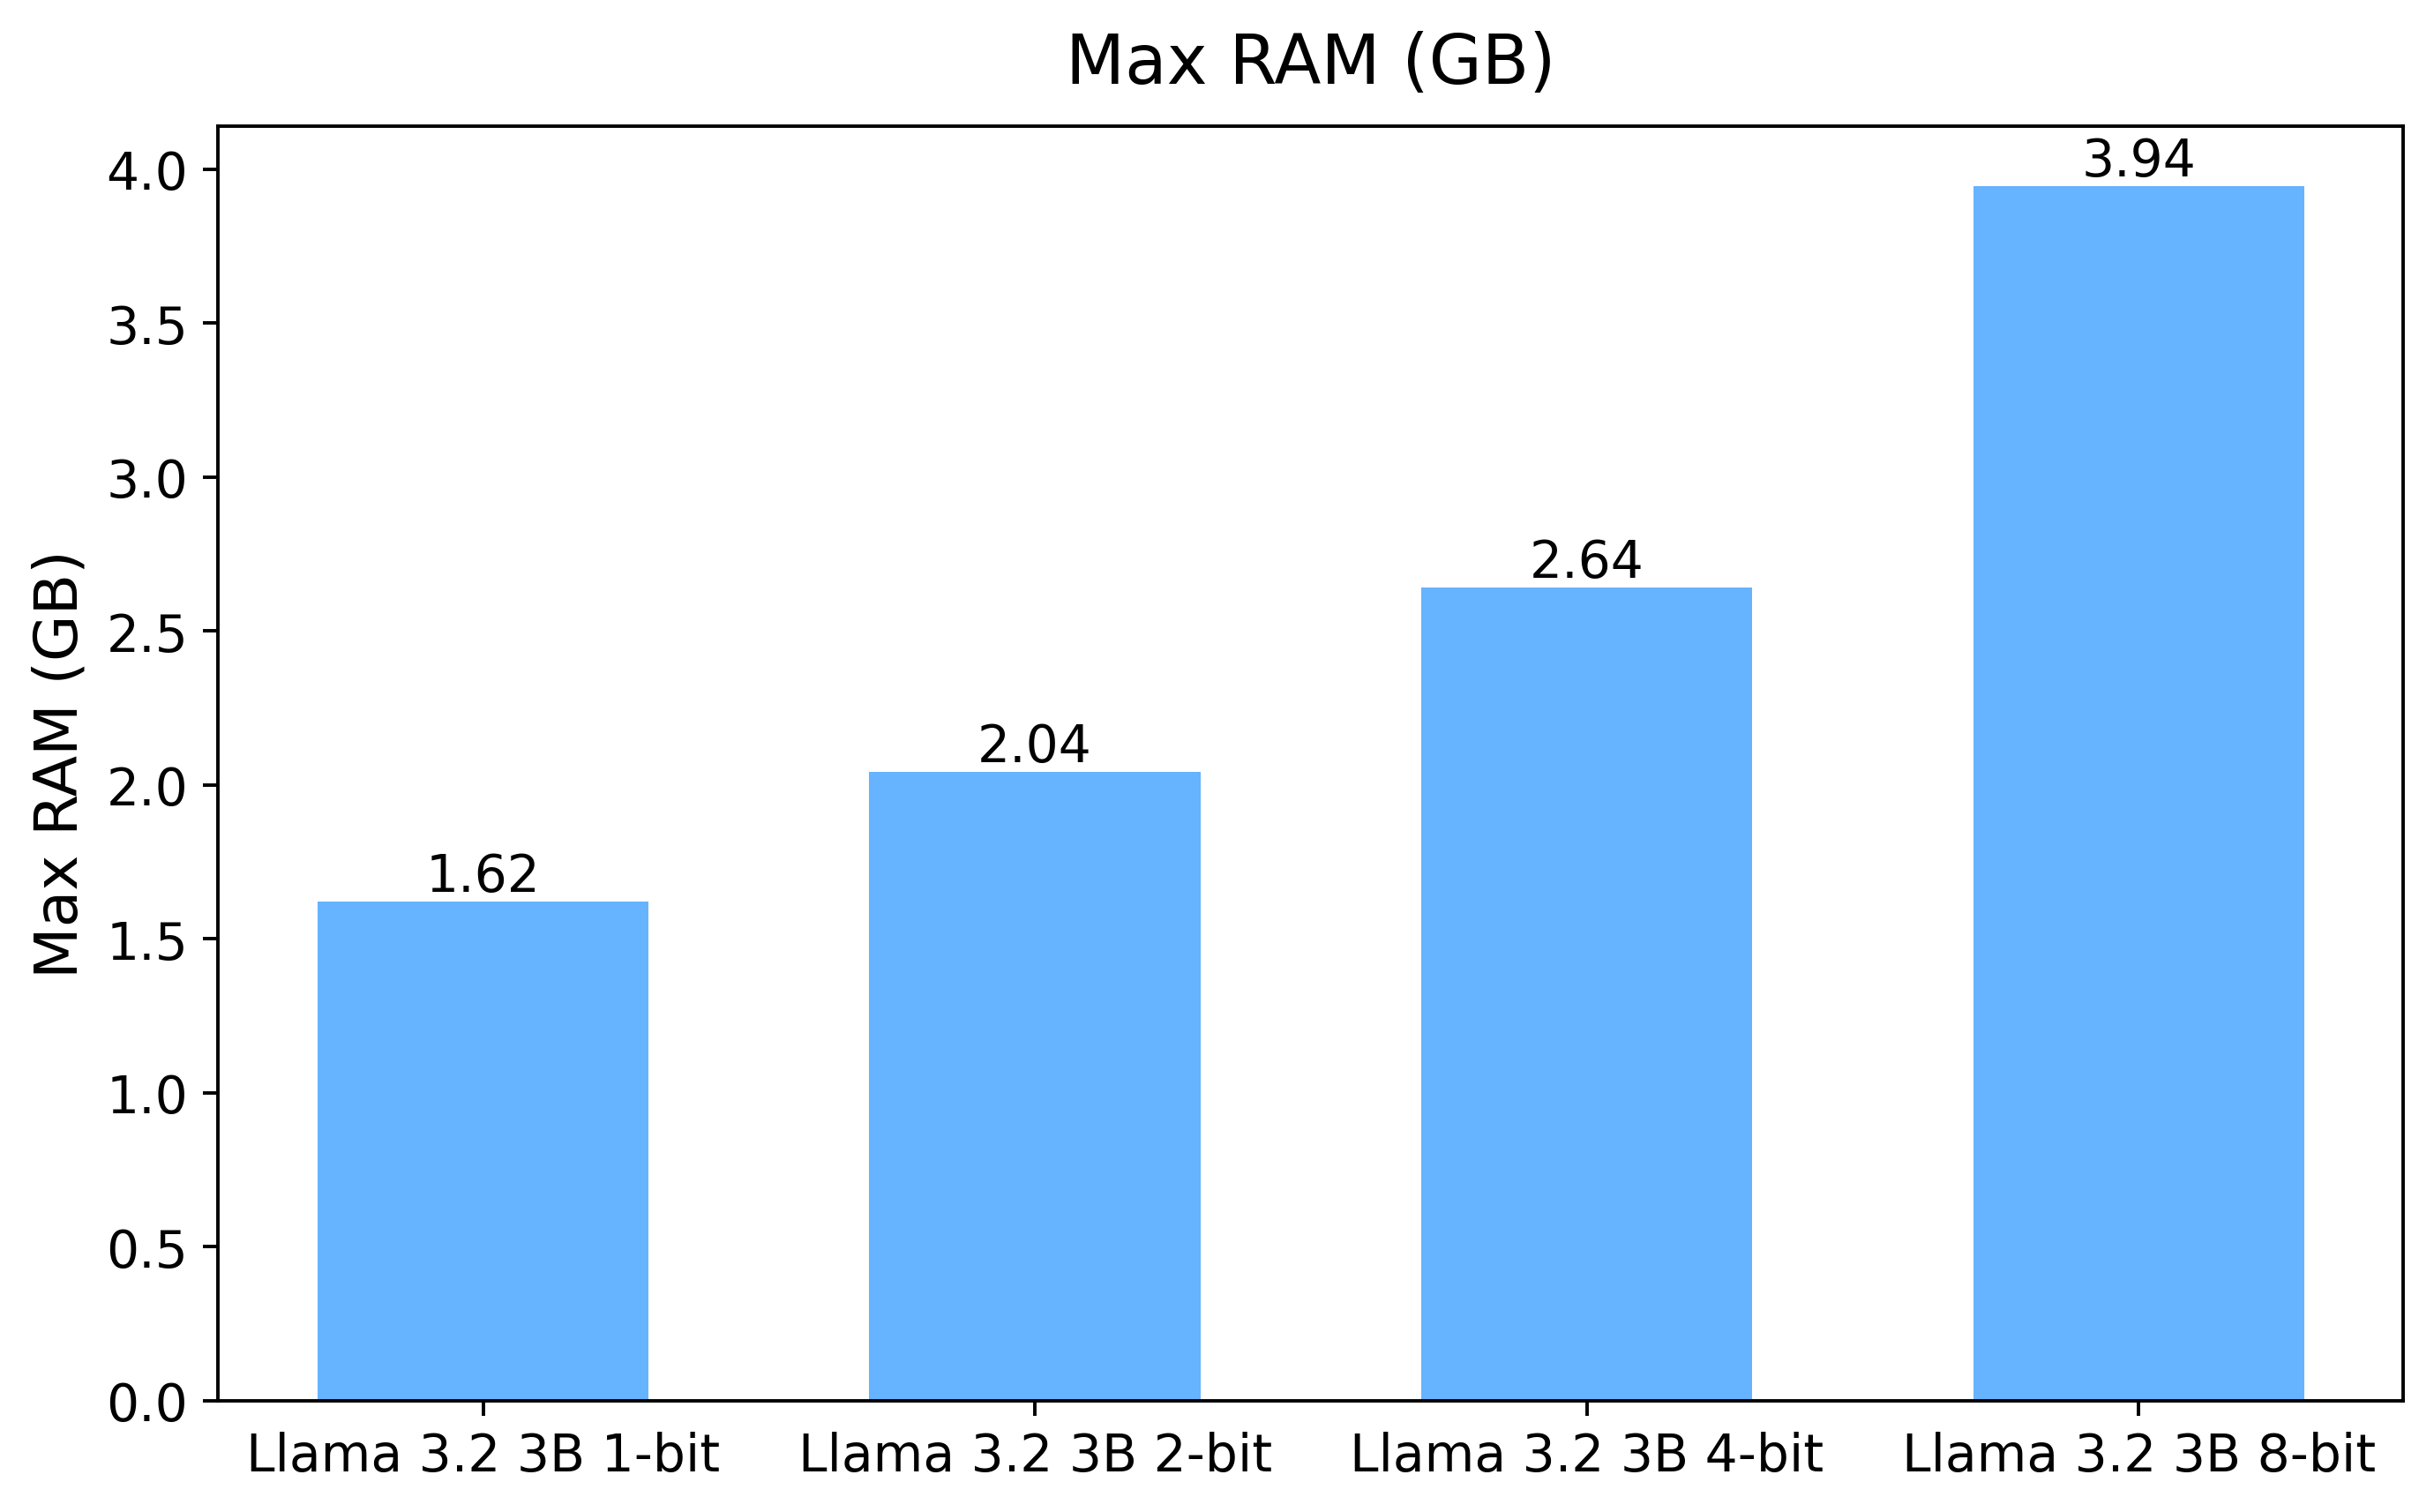

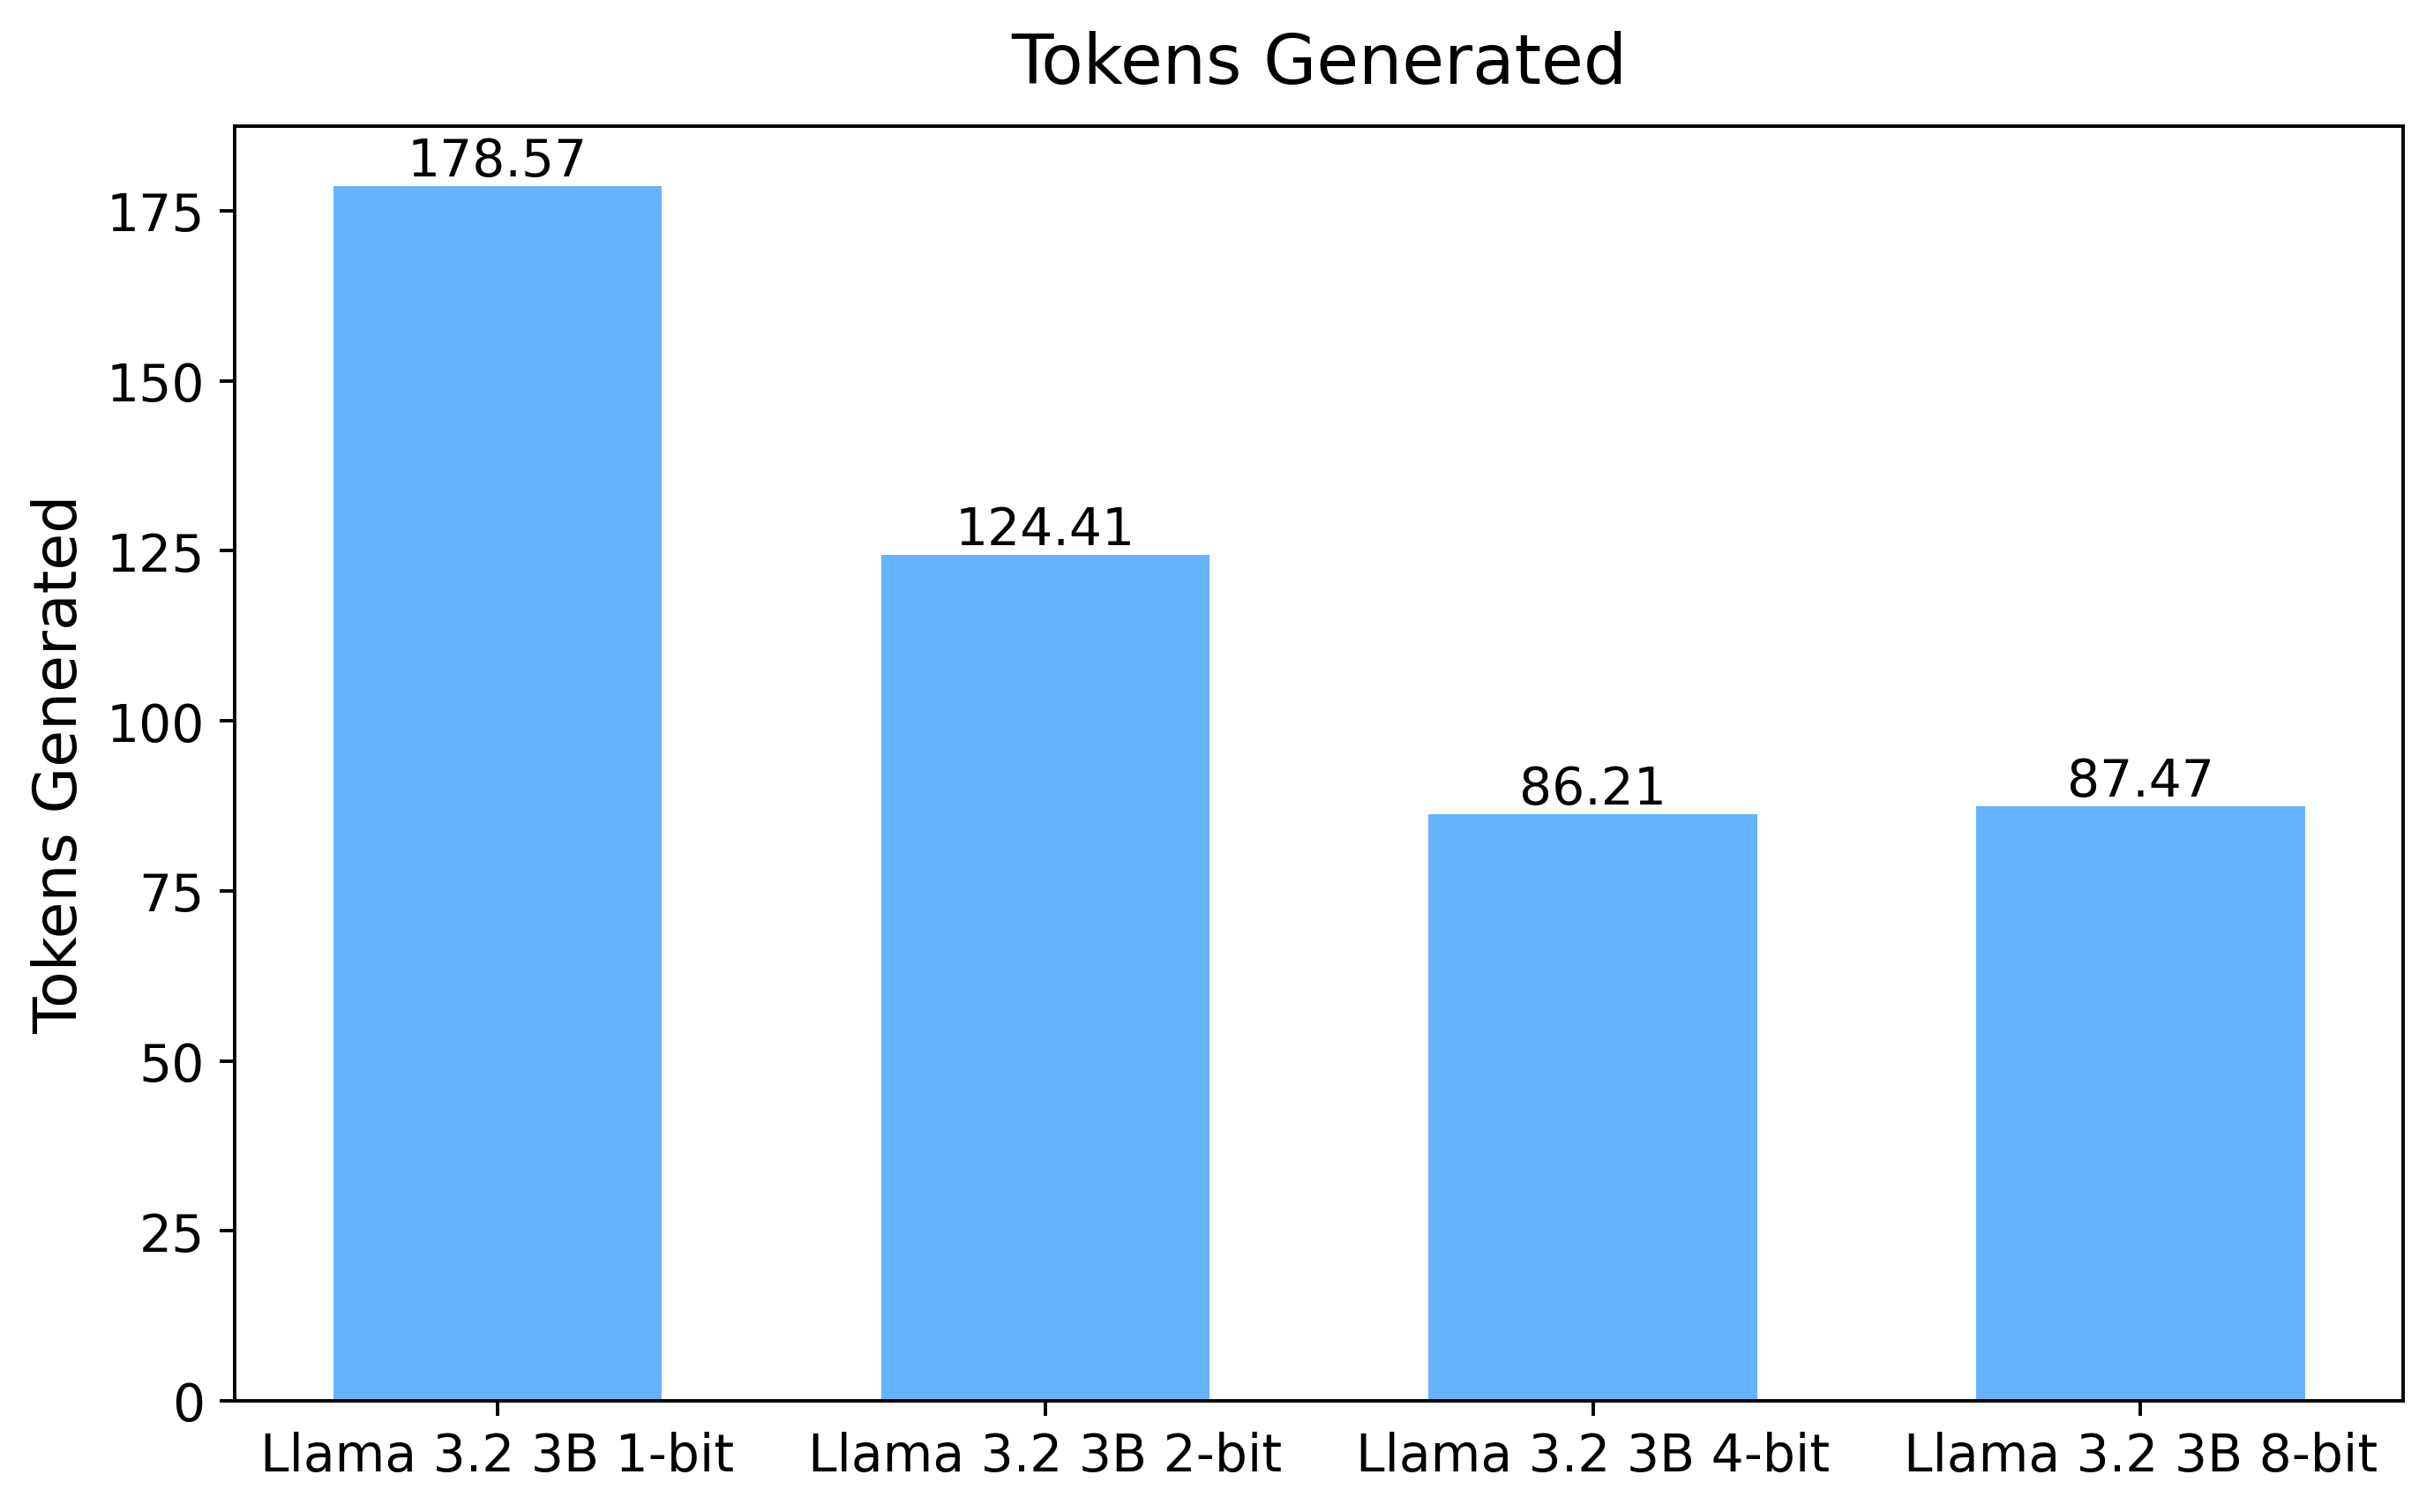

In [24]:
model_names = [ 'Llama 3.2 3B 1-bit',
 'Llama 3.2 3B 2-bit',
 'Llama 3.2 3B 4-bit',
 'Llama 3.2 3B 8-bit']

metrics = ['Accuracy', 'Latency', 'Throughput', 'Max RAM', 'Tokens Generated']
units = ["", "s", "tokens/s", "GB", ""]
plot_model_metrics(model_names, metrics, units, final_model_results)

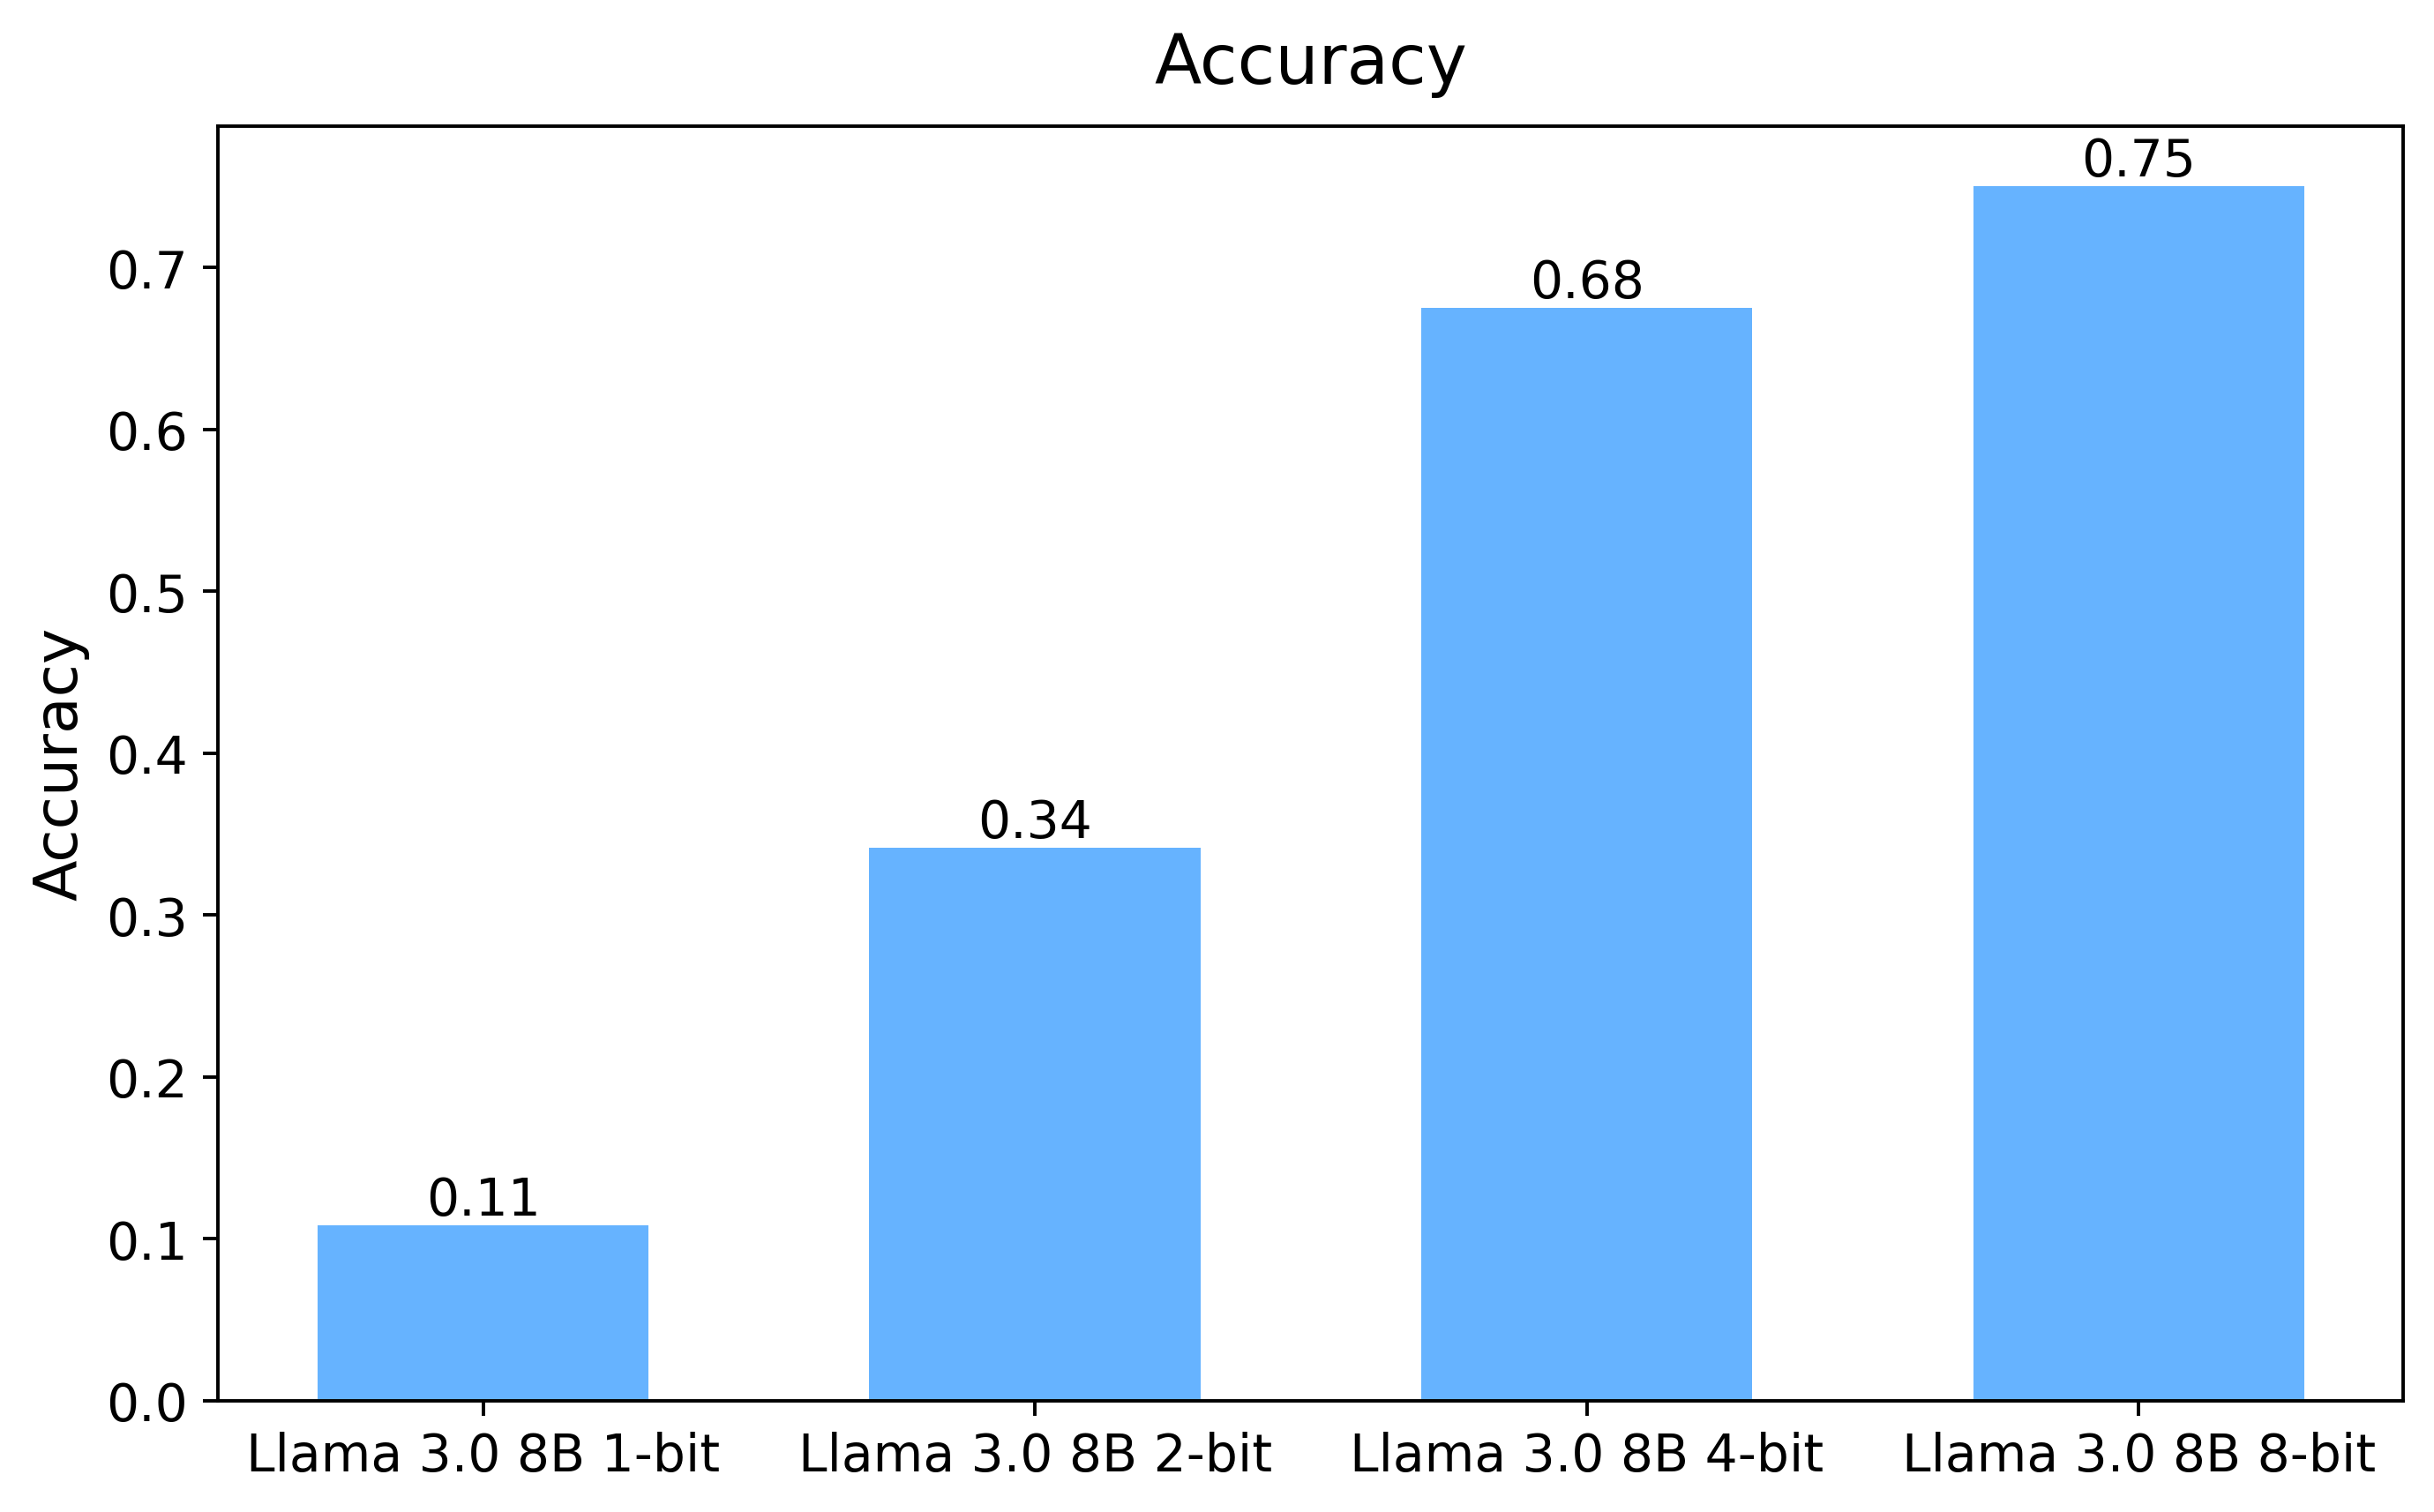

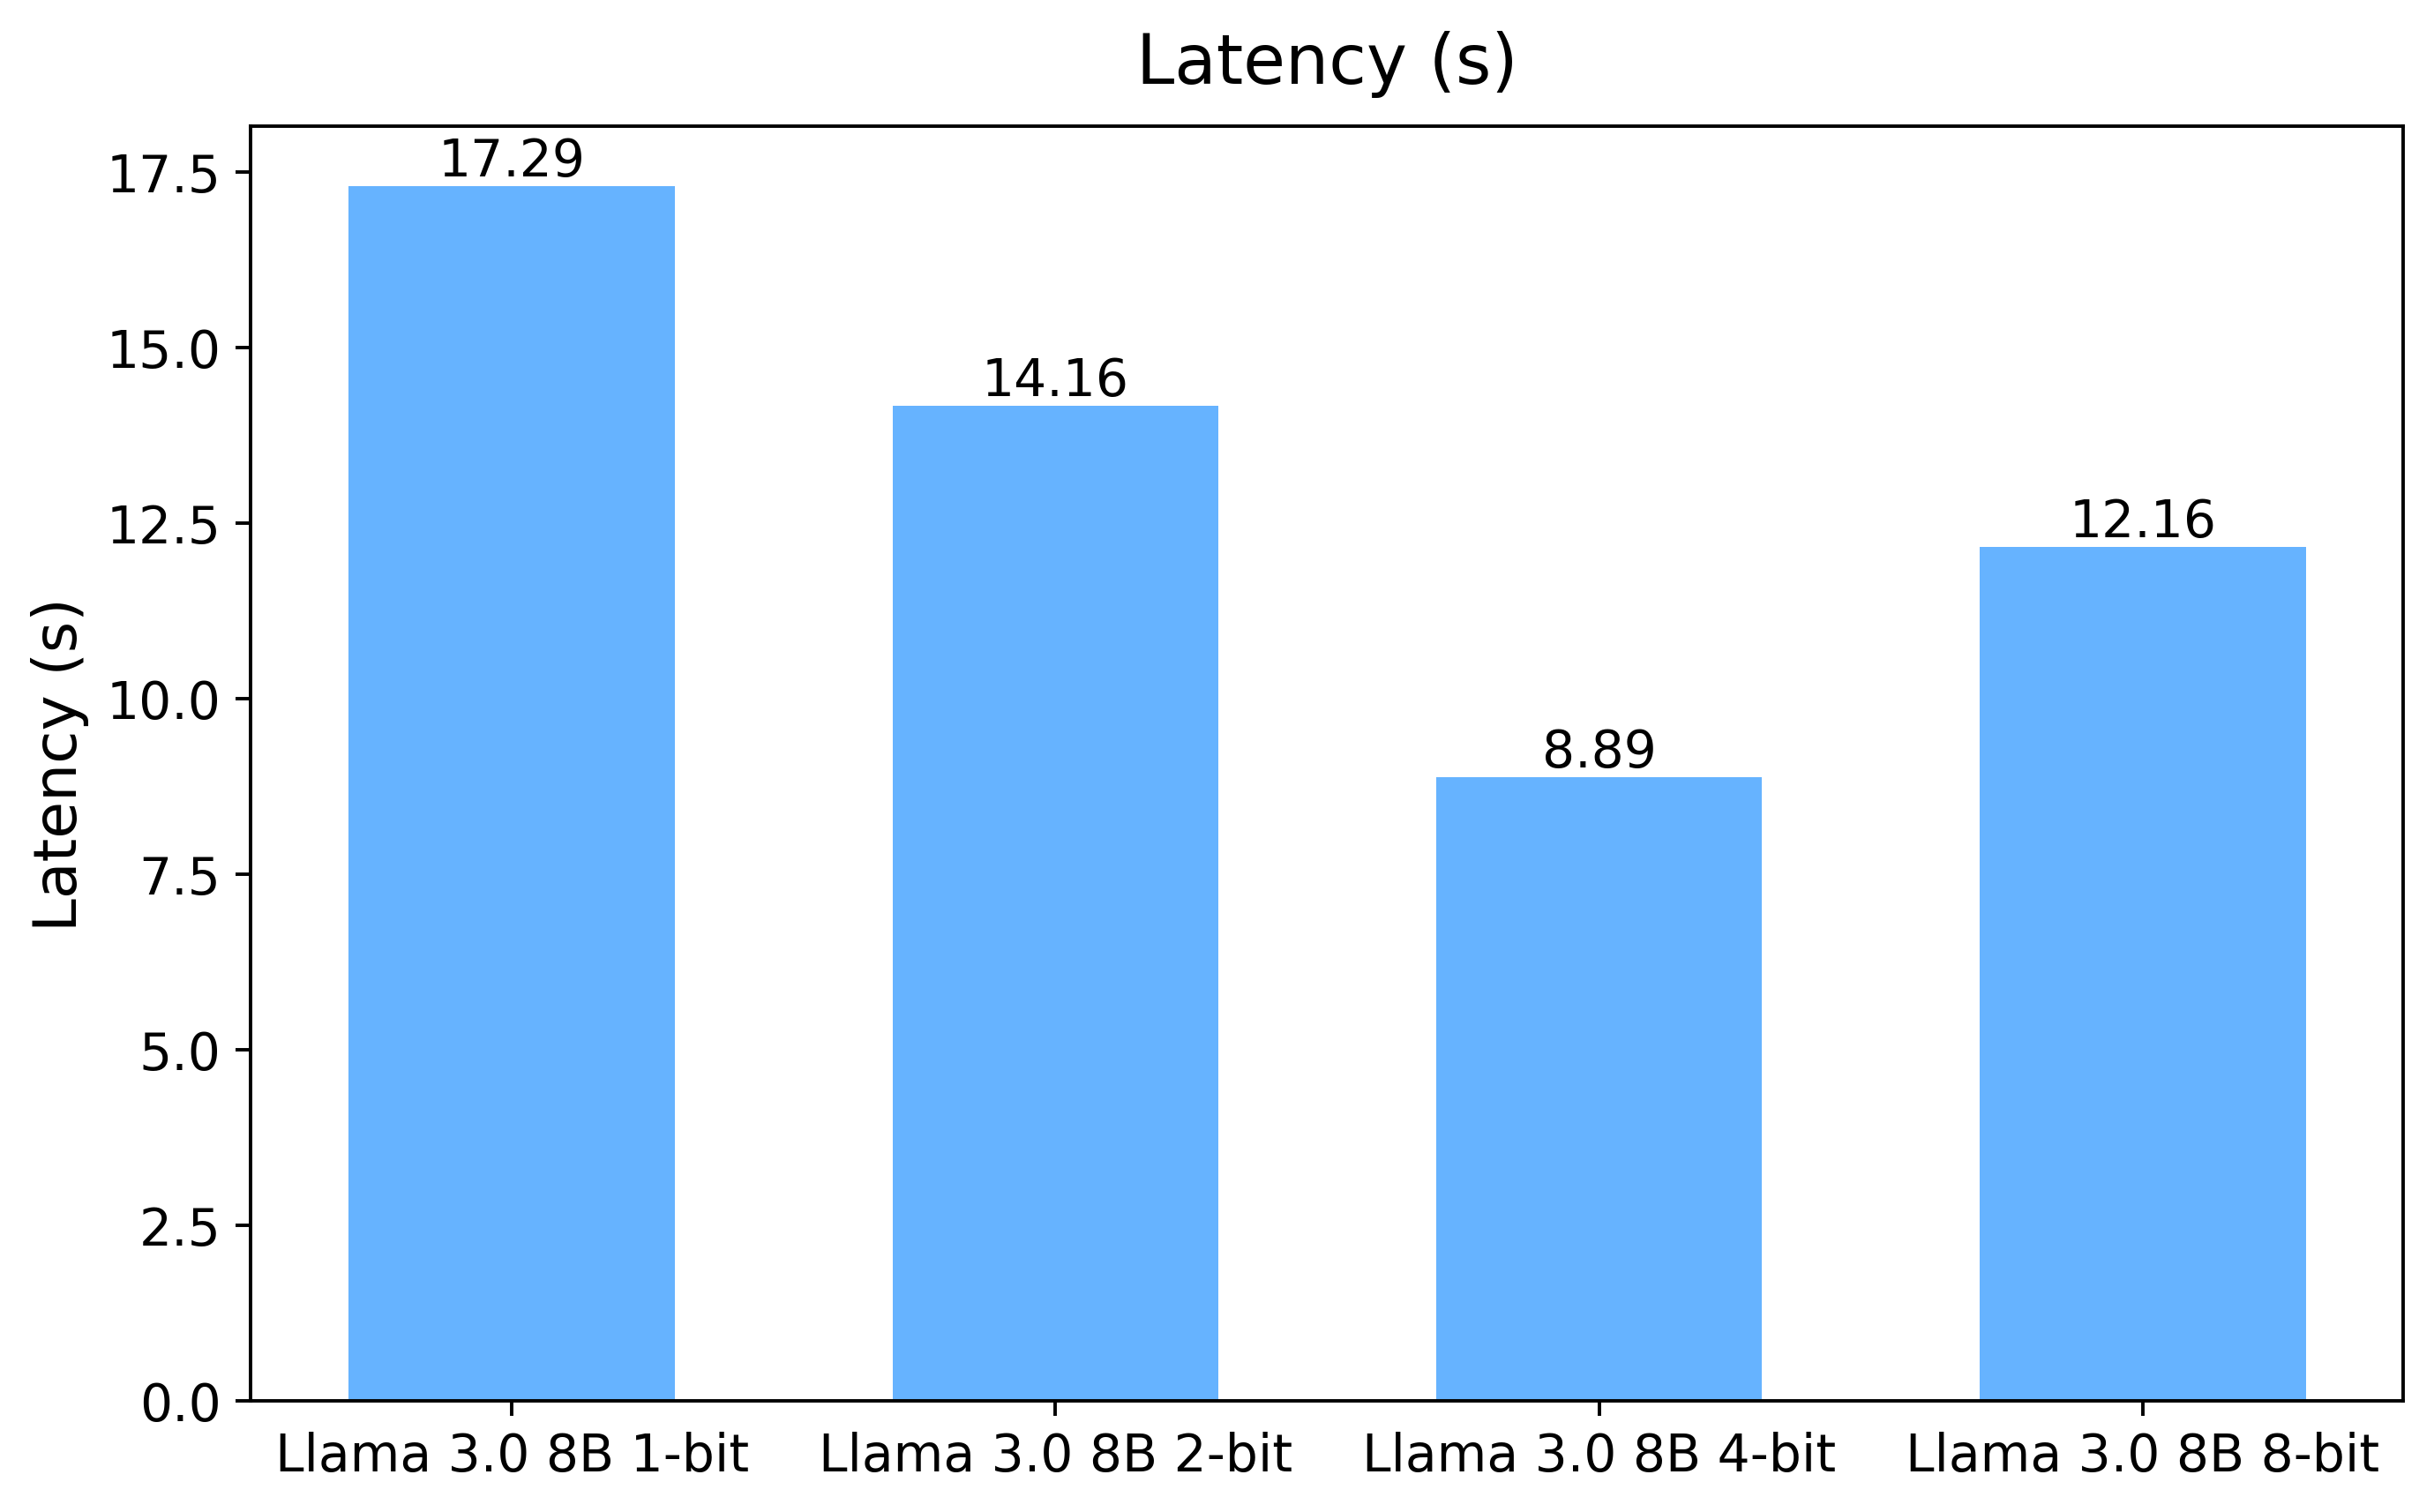

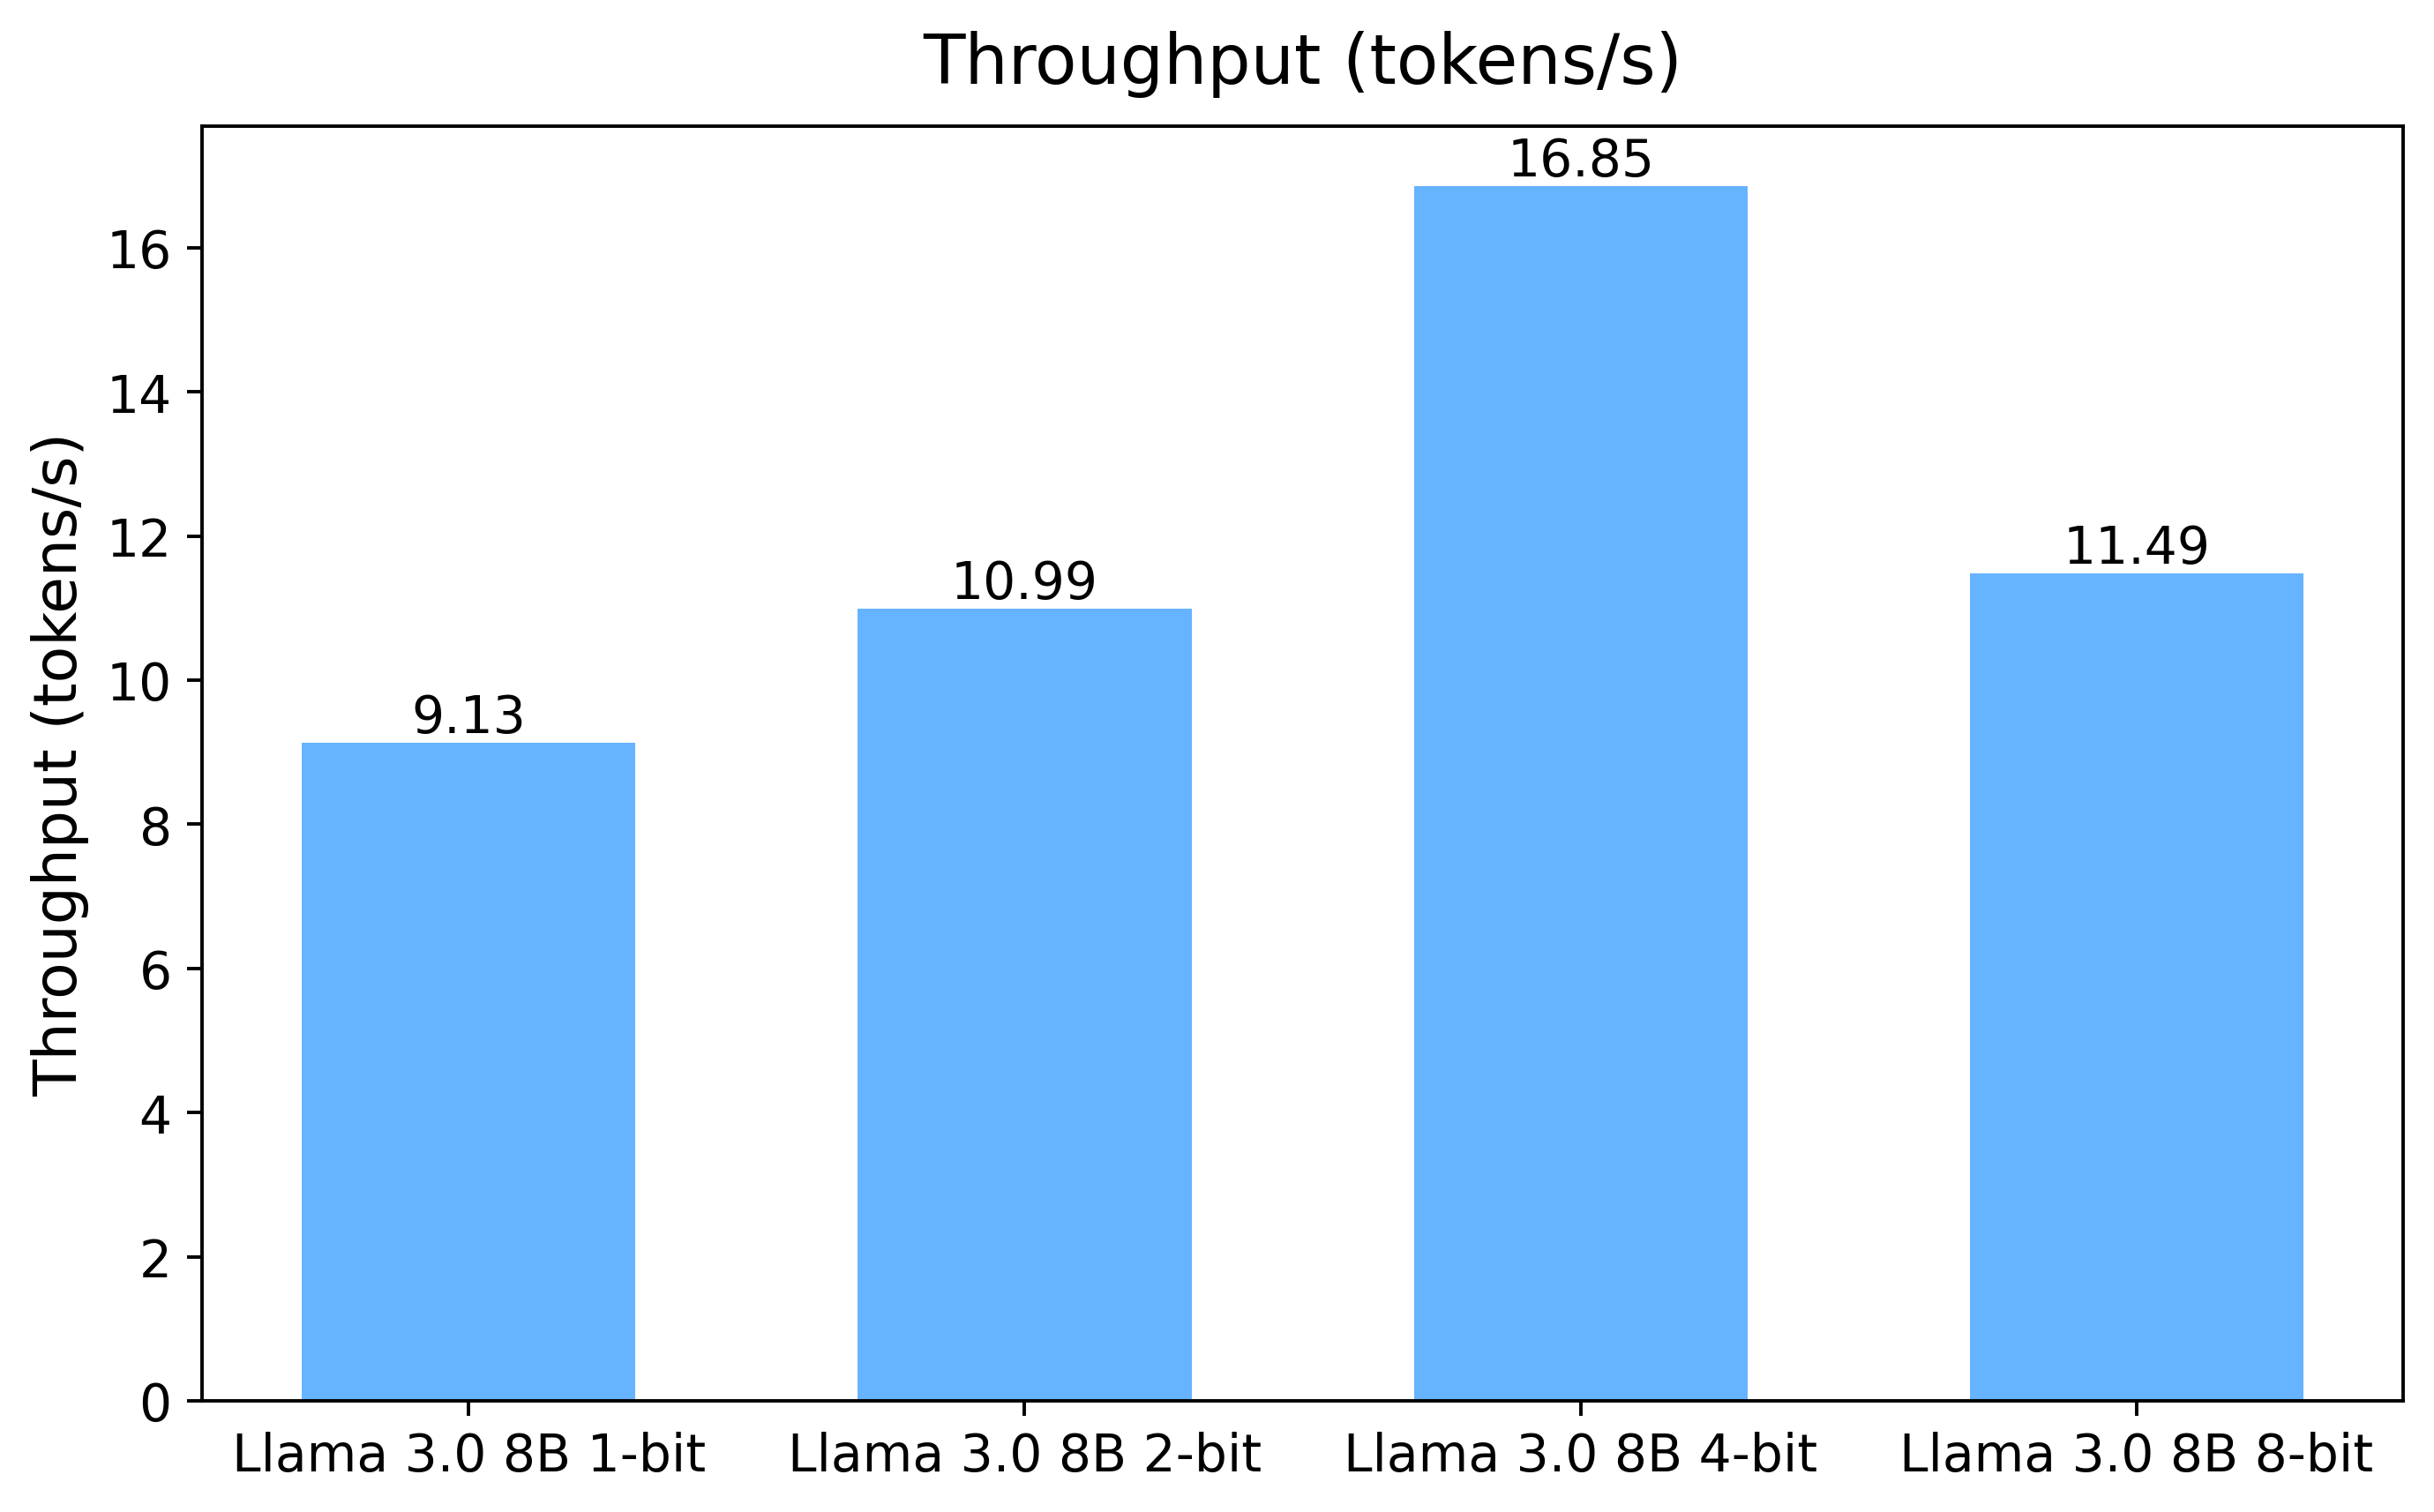

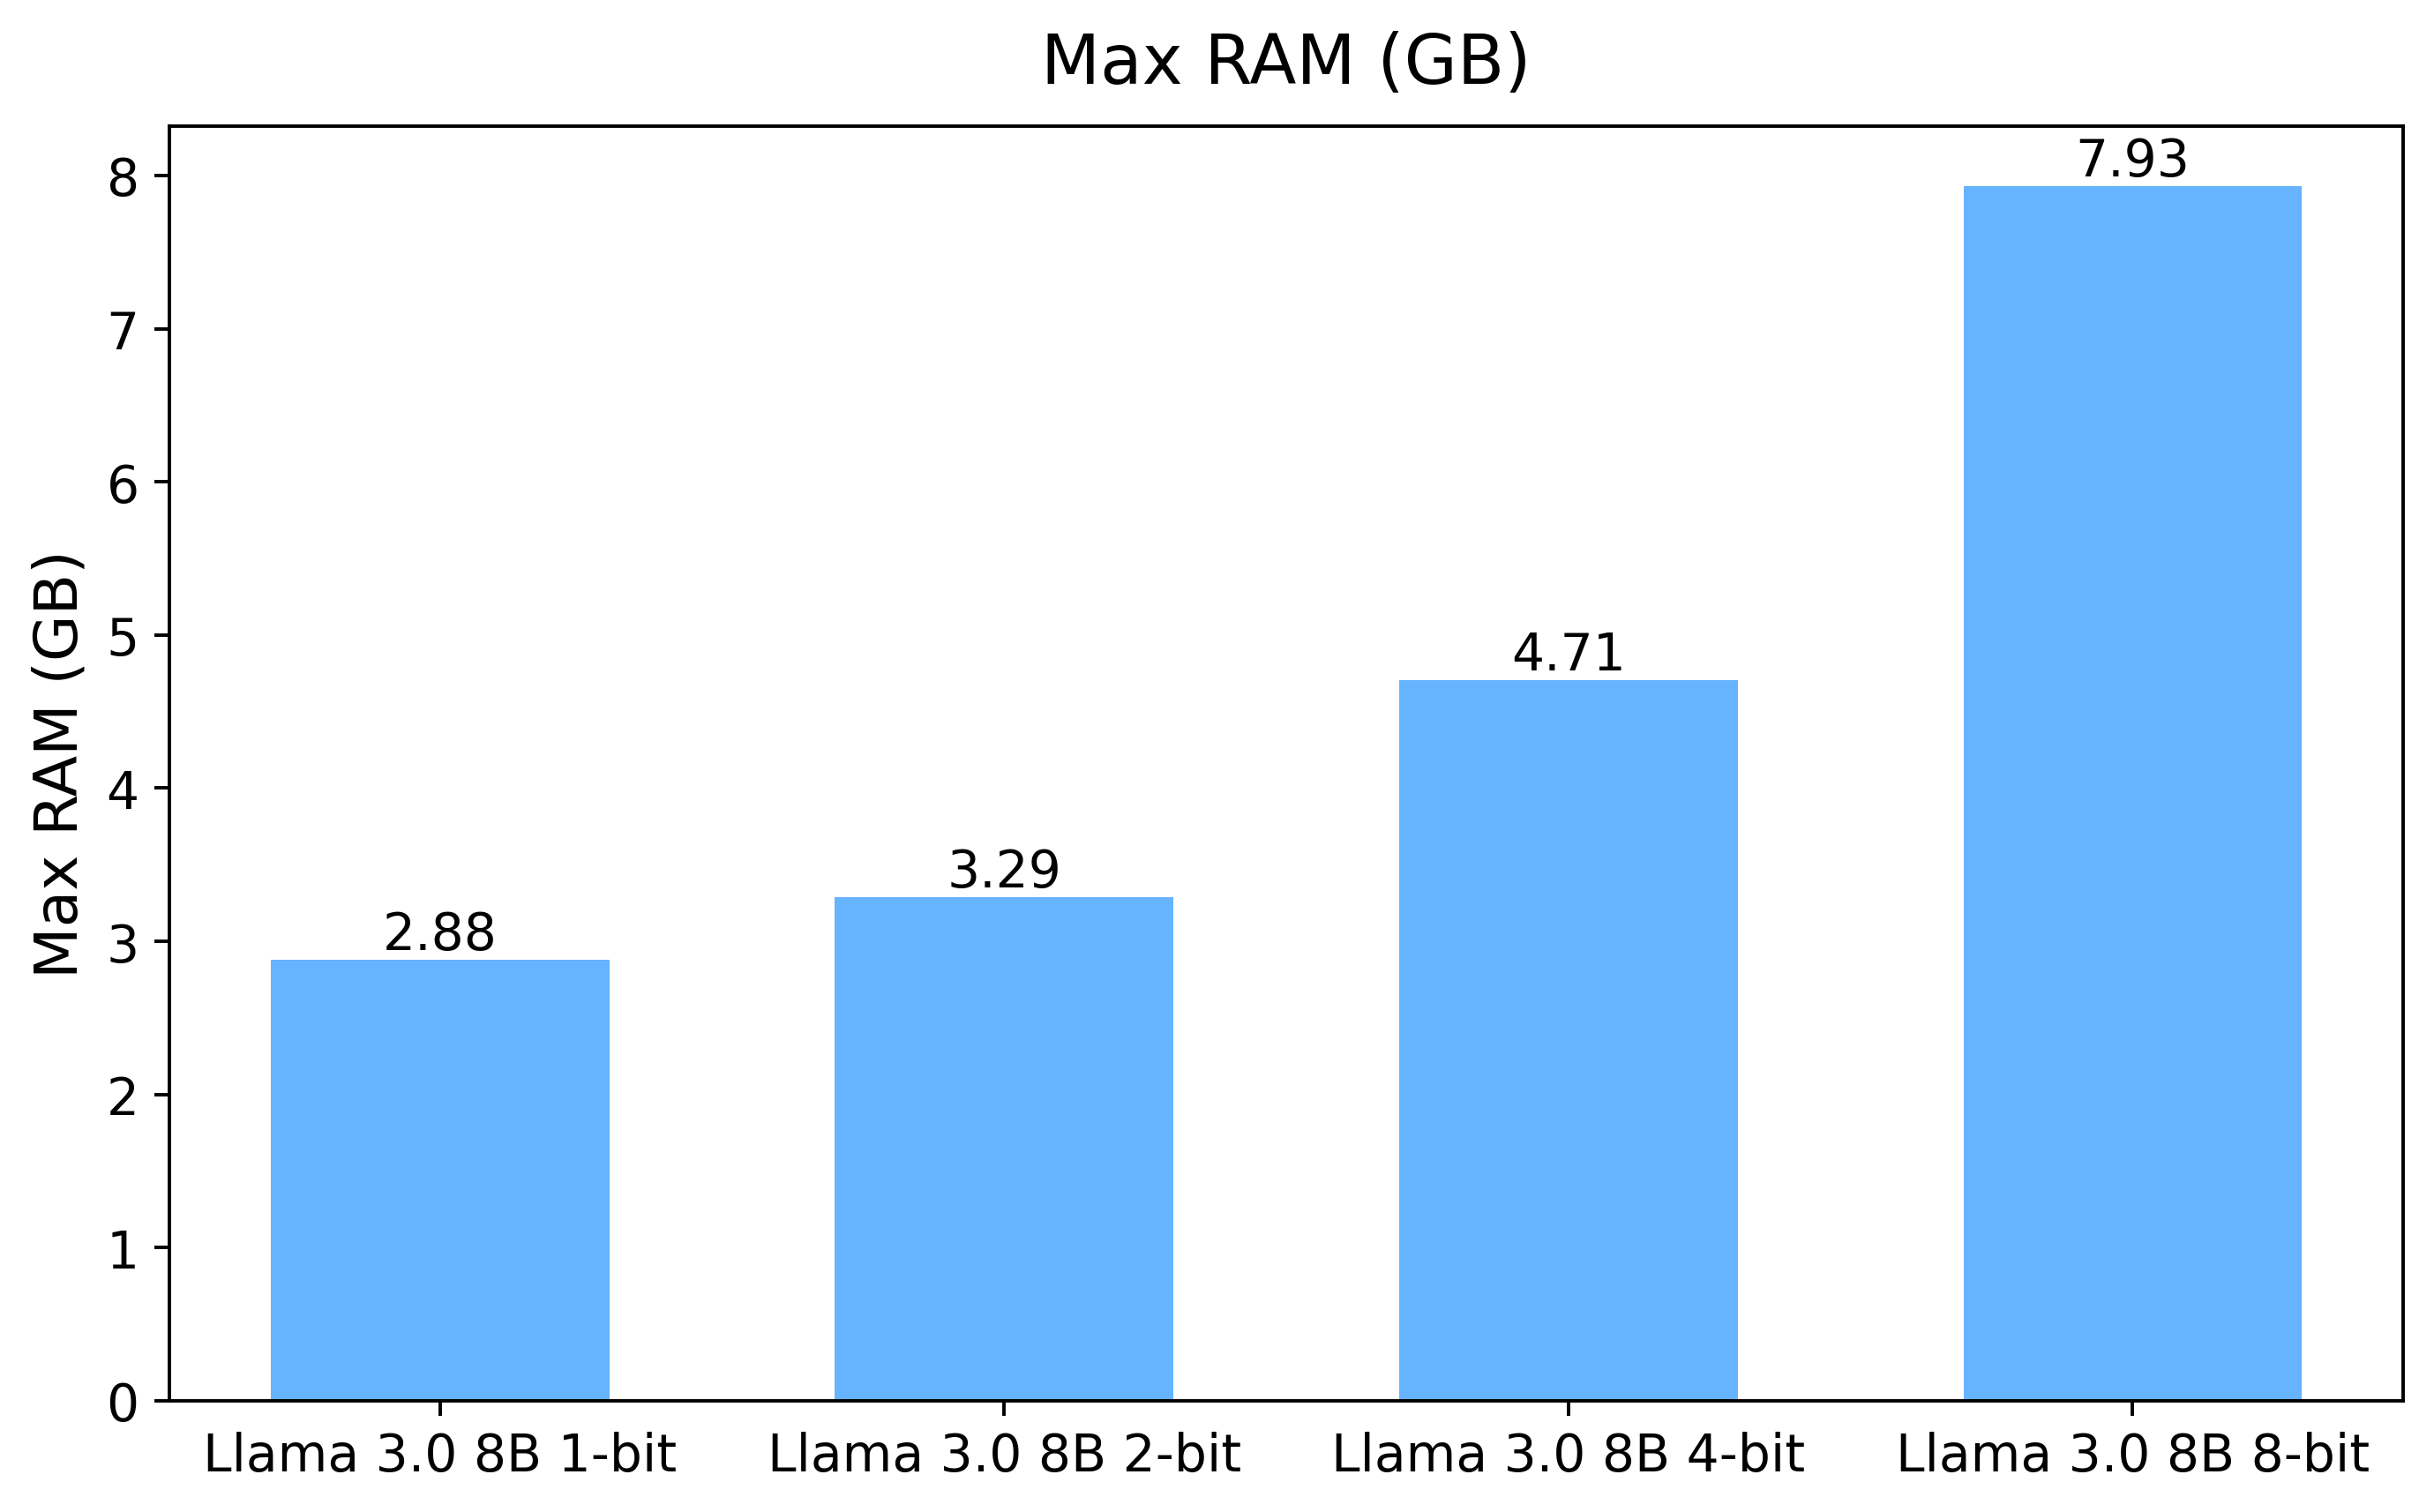

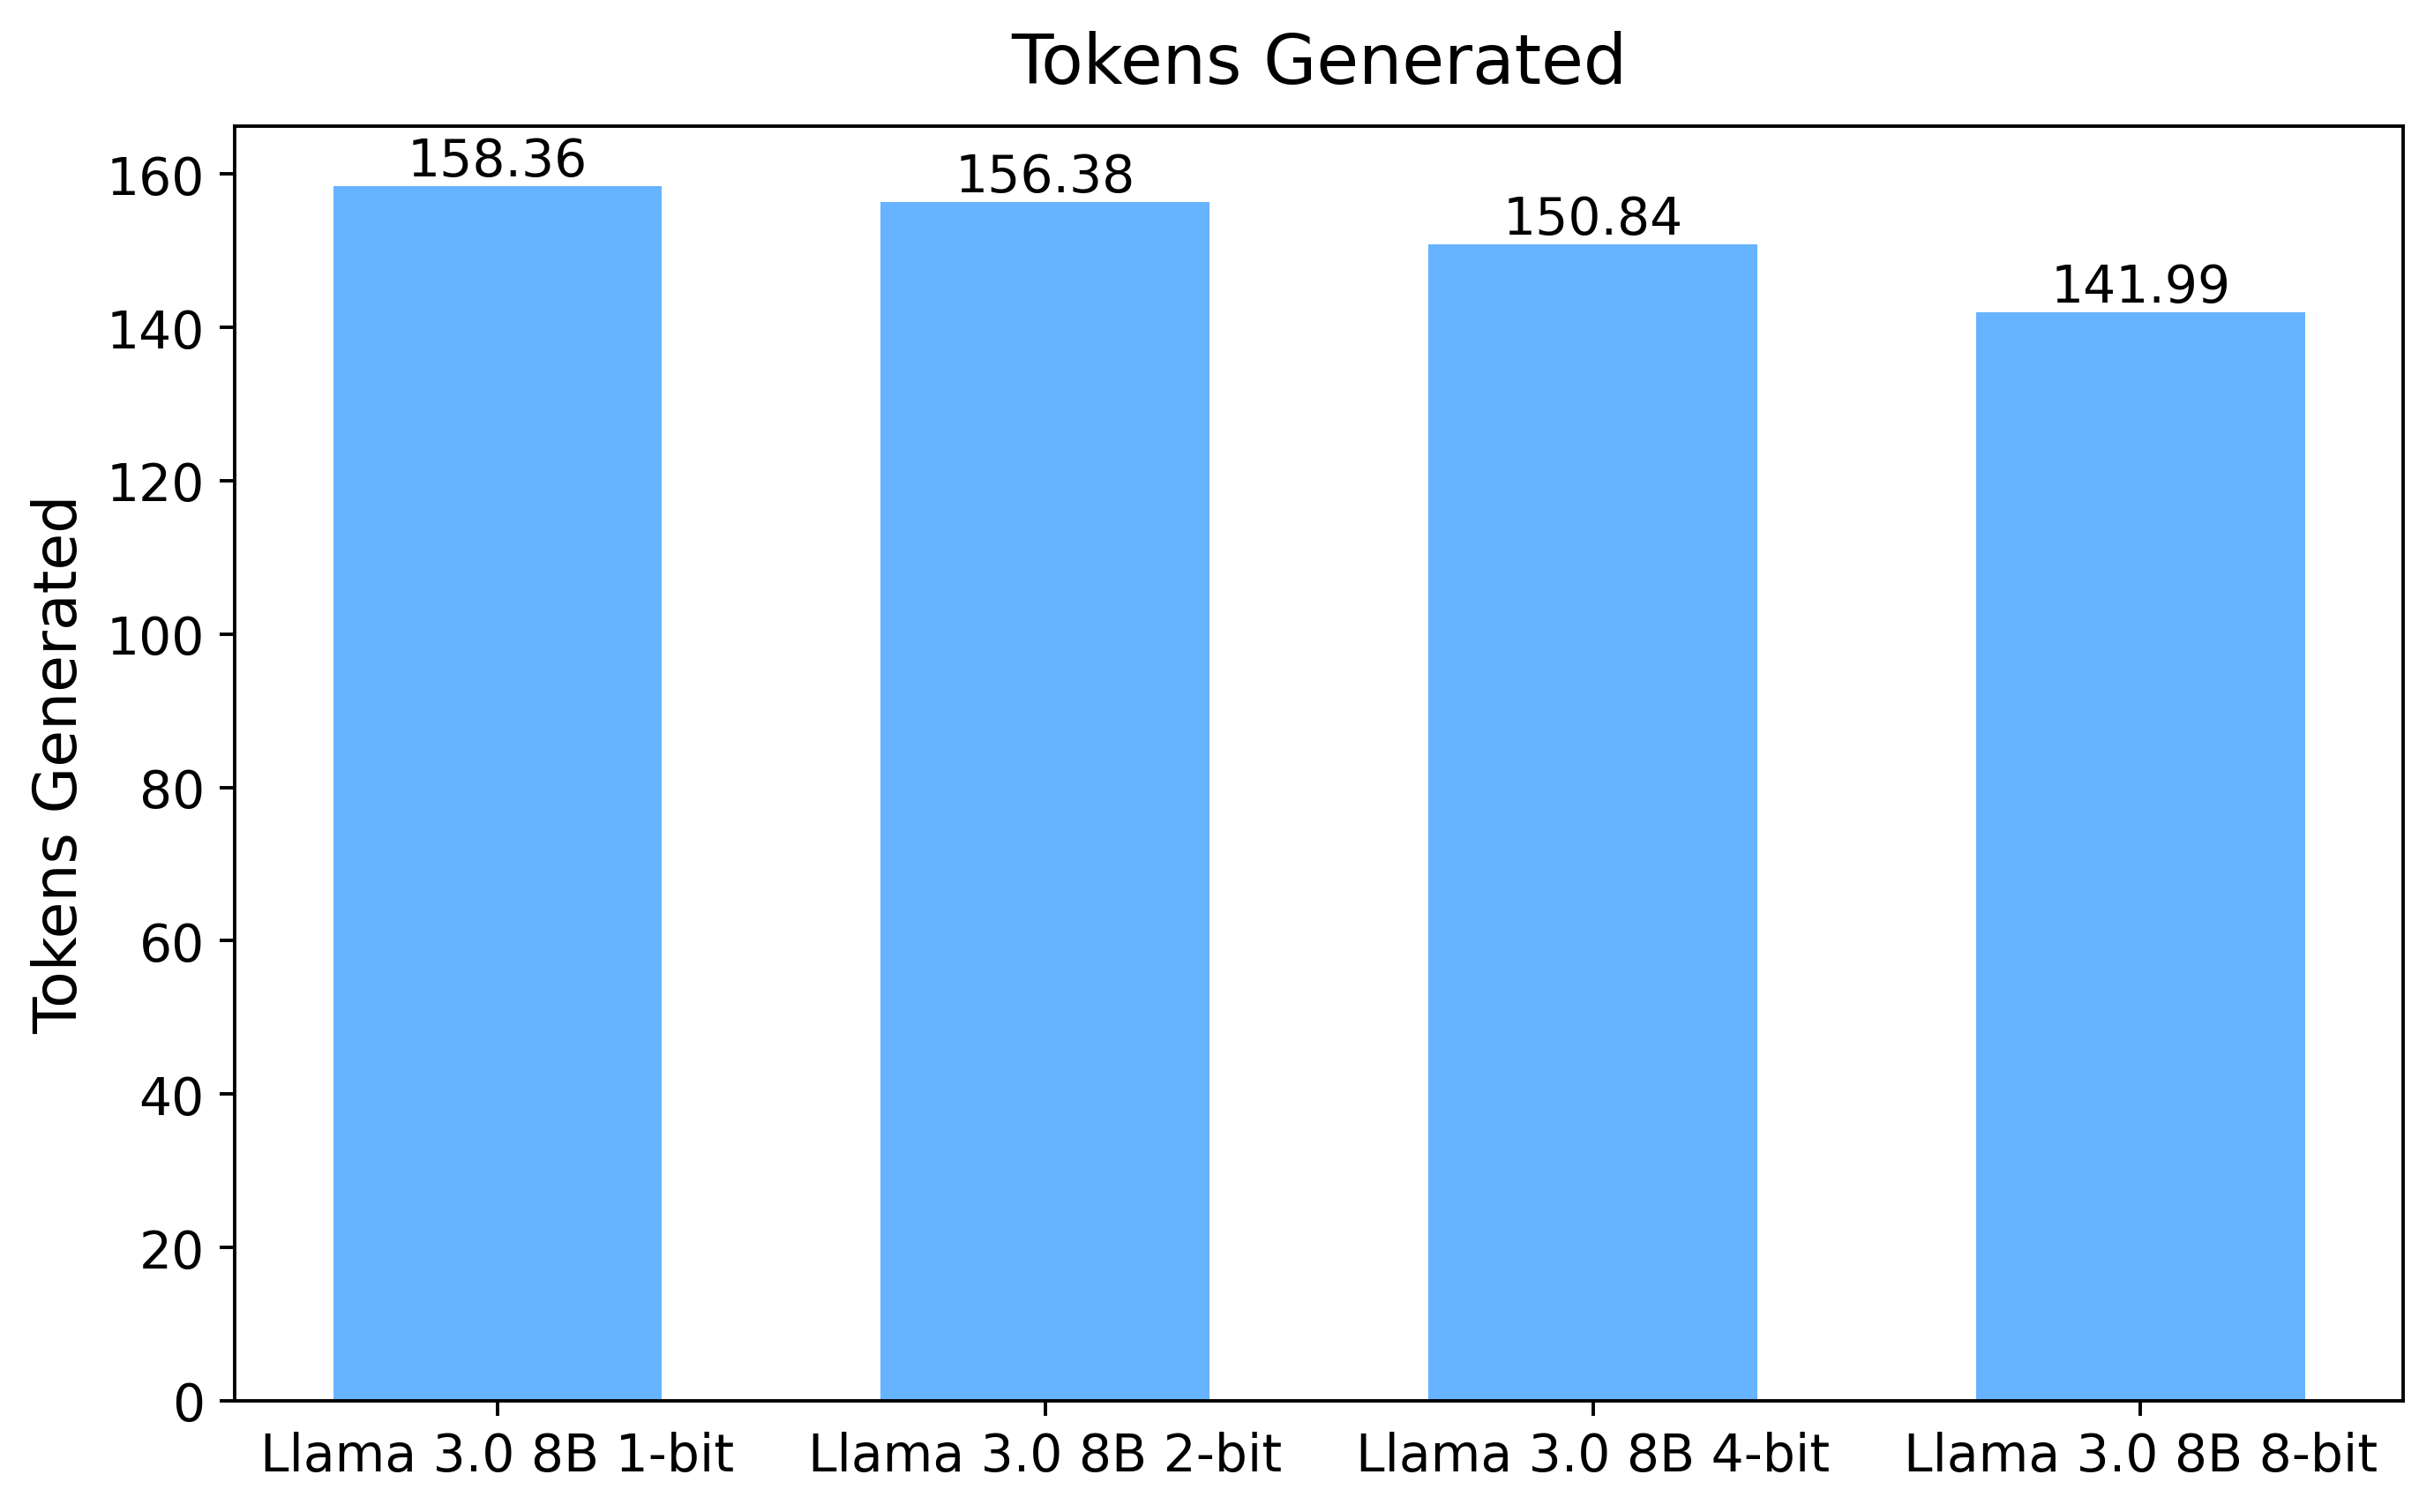

In [25]:
model_names = [ 'Llama 3.0 8B 1-bit',
 'Llama 3.0 8B 2-bit',
 'Llama 3.0 8B 4-bit',
 'Llama 3.0 8B 8-bit']

metrics = ['Accuracy', 'Latency', 'Throughput', 'Max RAM', 'Tokens Generated']
units = ["", "s", "tokens/s", "GB", ""]
plot_model_metrics(model_names, metrics, units, final_model_results)

1. 

Accuracy, latency, throughput, max ram -> different models, different sizes, different quantizations 


2. 

Deepseek models  (their corresponding models in 1):
Accuracy, latency, throughput, max ram, max_tokens -> different models, different sizes, different quantizations